In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, Dataset
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.subplots as sp

import util

# Load and Preprocess Data

In [2]:
# Load Data
data = pd.read_csv('DataImpurityGAN.csv')
# Drop First Column
data = data.drop(columns='Primary ID')

In [3]:
# Drop NAN
data = data.dropna()

# Here we split the two classes into different dataframes

In [4]:
# Group the data by the "Class" column
grouped_data = data.groupby('Class')

# Create an empty dictionary to store the DataFrames
dfs = {}

# Iterate over each group and store the data in the dictionary
for class_, group in grouped_data:
    dfs[class_] = group.copy()

# Access the separate DataFrames
df_class_1 = dfs[1]
df_class_2 = dfs[2]


In [5]:
# Now that we have two different dataframes we can drop class column
df_class_1 = df_class_1.drop(columns= 'Class')
df_class_2 = df_class_2.drop(columns= 'Class')

In [6]:
# util.df_plot(df_class_2)

In [7]:
df_class_1.shape, df_class_2.shape

((2720, 45), (7085, 45))

In [8]:
# Column Names saved for later when we remake DataFrames
column_names = df_class_2.columns
# column_names

In [9]:
# Here we Scale the data
# Create an instance of StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit the scaler to data
scaler1.fit(df_class_2)
scaler2.fit(df_class_2)

# Transform the data to Standard scale
target_1 = scaler1.transform(df_class_1)
target_2 = scaler2.transform(df_class_2)
target_2.shape, target_1.shape

((7085, 45), (2720, 45))

In [10]:
# Specify length of training data first we train the class 2 since it has more data
num_data = 5000
target_1 = pd.DataFrame(target_2, columns = column_names).iloc[:(num_data-3000)]
target_2 = pd.DataFrame(target_2, columns = column_names).iloc[:num_data]
target_2.shape, target_1.shape

((5000, 45), (2000, 45))

# Parameters

In [11]:
# Parameters
input_dim = 45  # Input dimension
hidden_dim = 50  # Hidden dimension
output_dim = 8  # Output dimension (dimension of the embedded space)
encoding_dim = output_dim
noise_dim = output_dim
cond_dim = output_dim
seq_length = 10
input_channels = seq_length + 2
hidden_channels = 64
num_epochs = 250  # Number of training epochs
lr = 0.0001  # Learning rate
# length of the input sequence, which is the number of historical data points that will be used to predict futere timesteps

# sequence of future data that the model should try to predict
output_steps = 10
# batch size is the size of data used in training
batch_size = 32
# Create a loss function and an optimizer
criterion = nn.MSELoss()

In [12]:
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EmbeddingNetwork, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU()
    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_dim)
        out, _ = self.gru(x)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

class RecoveryNetwork(nn.Module):
    def __init__(self, output_dim, hidden_dim, input_dim):
        super(RecoveryNetwork, self).__init__()
        self.gru = nn.GRU(output_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, output_dim)
        out, _ = self.gru(x)
        out = self.linear(out)
        return out

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, index):
        return self.data[index:index+self.seq_length]

In [14]:
# instantiate the dataset and dataloader
dataset = TimeSeriesDataset(target_2, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [15]:
losses = []
embedding_network = EmbeddingNetwork(input_dim, hidden_dim, encoding_dim)
recovery_network = RecoveryNetwork(encoding_dim, hidden_dim, input_dim)

embedding_optimizer = torch.optim.Adam(embedding_network.parameters(), lr=lr, weight_decay=1e-5)
recovery_optimizer = torch.optim.Adam(recovery_network.parameters(), lr=lr, weight_decay=1e-5)

for epoch in range(num_epochs):
    for seqs_in in dataloader:
        
        # Ensure the seqs are of correct size
        seqs_in = seqs_in.view(seqs_in.size(0), -1, input_dim)
        
        # Zero the gradients
        embedding_optimizer.zero_grad()
        recovery_optimizer.zero_grad()

        # Pass the input sequences through the autoencoder
        encoded = embedding_network(seqs_in)
        decoded = recovery_network(encoded)

        # Calculate the loss
        loss = criterion(decoded, seqs_in)  # The goal is to reconstruct the input sequences
        
        # Backward propagation
        loss.backward()

        # Update the weights
        embedding_optimizer.step()
        recovery_optimizer.step()

    losses.append(loss)
    # Print loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/250, Loss: 1.2923684120178223
Epoch 2/250, Loss: 1.3243277072906494
Epoch 3/250, Loss: 1.312188744544983
Epoch 4/250, Loss: 1.2106621265411377
Epoch 5/250, Loss: 1.082728385925293
Epoch 6/250, Loss: 1.0532658100128174
Epoch 7/250, Loss: 1.0606194734573364
Epoch 8/250, Loss: 1.0711668729782104
Epoch 9/250, Loss: 1.0760349035263062
Epoch 10/250, Loss: 1.0744394063949585
Epoch 11/250, Loss: 1.0672407150268555
Epoch 12/250, Loss: 1.0557806491851807
Epoch 13/250, Loss: 1.042080283164978
Epoch 14/250, Loss: 1.0289182662963867
Epoch 15/250, Loss: 1.0178214311599731
Epoch 16/250, Loss: 1.008935809135437
Epoch 17/250, Loss: 1.0019779205322266
Epoch 18/250, Loss: 0.996192455291748
Epoch 19/250, Loss: 0.9910079836845398
Epoch 20/250, Loss: 0.9861350059509277
Epoch 21/250, Loss: 0.9814516305923462
Epoch 22/250, Loss: 0.9769123196601868
Epoch 23/250, Loss: 0.9724975228309631
Epoch 24/250, Loss: 0.9681823253631592
Epoch 25/250, Loss: 0.9639214873313904
Epoch 26/250, Loss: 0.959659218788147
E

Epoch 209/250, Loss: 0.22548222541809082
Epoch 210/250, Loss: 0.22342640161514282
Epoch 211/250, Loss: 0.2217019647359848
Epoch 212/250, Loss: 0.22011694312095642
Epoch 213/250, Loss: 0.21838437020778656
Epoch 214/250, Loss: 0.21666374802589417
Epoch 215/250, Loss: 0.21507465839385986
Epoch 216/250, Loss: 0.21352998912334442
Epoch 217/250, Loss: 0.2120138257741928
Epoch 218/250, Loss: 0.21048972010612488
Epoch 219/250, Loss: 0.20896631479263306
Epoch 220/250, Loss: 0.20749571919441223
Epoch 221/250, Loss: 0.20613832771778107
Epoch 222/250, Loss: 0.2049694061279297
Epoch 223/250, Loss: 0.20395483076572418
Epoch 224/250, Loss: 0.20298242568969727
Epoch 225/250, Loss: 0.20200639963150024
Epoch 226/250, Loss: 0.2010505348443985
Epoch 227/250, Loss: 0.20011800527572632
Epoch 228/250, Loss: 0.19917738437652588
Epoch 229/250, Loss: 0.19819273054599762
Epoch 230/250, Loss: 0.1971634179353714
Epoch 231/250, Loss: 0.19614174962043762
Epoch 232/250, Loss: 0.19518789649009705
Epoch 233/250, Loss: 

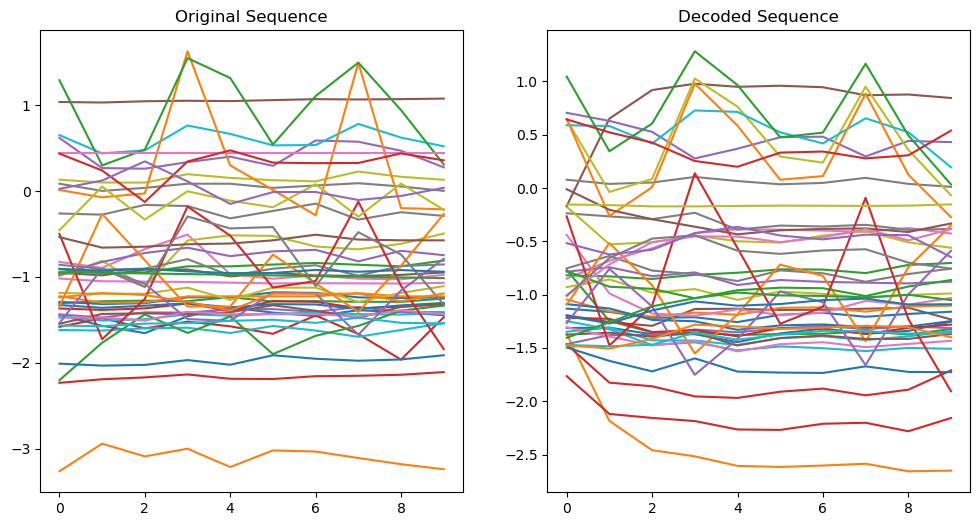

In [16]:
# Select a batch of data from your test loader
test_data_in = next(iter(dataloader))

# Pass the test data through the embedding and recovery networks
encoded = embedding_network(test_data_in)
decoded = recovery_network(encoded)

# Compare the recovery network's output to the original data
test_data_in = test_data_in.detach().numpy()
decoded = decoded.detach().numpy()

# Select first sequence for comparison
original_sequence = test_data_in[0]
decoded_sequence = decoded[0]

# Plotting
plt.figure(figsize=(12, 6))

# Plot original sequence
plt.subplot(1, 2, 1)
plt.plot(original_sequence)
plt.title("Original Sequence")

# Plot decoded sequence
plt.subplot(1, 2, 2)
plt.plot(decoded_sequence)
plt.title("Decoded Sequence")

plt.show()

In [17]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, cond_dim, hidden_dim, output_dim):
        super().__init__()
        self.noise_layer = nn.Linear(noise_dim, hidden_dim)
        self.condition_layer = nn.Linear(cond_dim, hidden_dim)
        self.gru = nn.GRU(input_size=hidden_dim*2, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, noise, condition):
        batch_size, seq_len, _ = noise.size()

        noise_embedding = F.relu(self.noise_layer(noise.view(batch_size * seq_len, -1)))
        noise_embedding = noise_embedding.view(batch_size, seq_len, -1)

        condition_embedding = F.relu(self.condition_layer(condition))
        condition_embedding = condition_embedding.unsqueeze(1).repeat(1, seq_len, 1)

        combined = torch.cat([noise_embedding, condition_embedding], dim=2)
        output, _ = self.gru(combined)
        output = self.fc(output)

        return torch.tanh(output)
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=256, out_features=1)

    def forward(self, x, condition):
        x = torch.cat([x, condition.unsqueeze(1)], dim=1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = torch.sigmoid(self.fc(x))

        return x

In [18]:
# Instantiate your models
generator = ConditionalGenerator(noise_dim, cond_dim, hidden_dim, output_dim)
discriminator = ConditionalDiscriminator(input_channels, hidden_channels, output_dim)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [19]:
# Assuming you have the data loader already
num_epochs = 200

gen_losses = []
dis_losses = []
rec_losses = []
for epoch in range(num_epochs):
    for batch in dataloader:
        # Move the batch data to the device
        # Get the condition (the last time point of the previous input)
        # Assuming batch has shape (batch_size, seq_len, input_dim)
        
        # Encode the data
        encoded = embedding_network(batch)
        condition = encoded[:,0,:]

        # Generate fake data
        noise = torch.randn(encoded.shape)
        generated = generator(noise, condition)

        # Discriminator loss
        real_data = torch.cat((encoded, condition.unsqueeze(1)), dim=1)  # Add extra dimension to condition
        fake_data = torch.cat((generated, condition.unsqueeze(1)), dim=1)
        real_preds = discriminator(real_data, condition)
        fake_preds = discriminator(fake_data.detach(), condition)  # Detach so we don't backprop through G

        real_loss = F.binary_cross_entropy(real_preds, torch.ones_like(real_preds))
        fake_loss = F.binary_cross_entropy(fake_preds, torch.zeros_like(fake_preds))
        discriminator_loss = (real_loss + fake_loss) / 2

        # Backprop and update D weights
        discriminator.zero_grad()
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

        # Generator loss
        fake_preds = discriminator(fake_data, condition)
        # Changed to Mean Squared Error loss
        generator_loss = F.mse_loss(fake_preds, torch.ones_like(fake_preds))

        # Backprop and update G weights
        generator.zero_grad()
        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Decode the generated data and compute reconstruction loss
        recovery = recovery_network(generated)
        # Compute MSE between the recovery and the original data
        rec_loss = F.mse_loss(recovery, batch)
    rec_losses.append(rec_loss)
    gen_losses.append(generator_loss)
    dis_losses.append(discriminator_loss)
    # Print loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Generator Loss: {generator_loss.item()}, Discriminator Loss: {discriminator_loss.item()}, Reconstruction Loss: {rec_loss.item()}')

Epoch 1/200, Generator Loss: 0.25576141476631165, Discriminator Loss: 0.6999072432518005, Reconstruction Loss: 2.093906879425049
Epoch 2/200, Generator Loss: 0.30234867334365845, Discriminator Loss: 0.6806180477142334, Reconstruction Loss: 1.585598349571228
Epoch 3/200, Generator Loss: 0.3426484763622284, Discriminator Loss: 0.6357903480529785, Reconstruction Loss: 1.0331910848617554
Epoch 4/200, Generator Loss: 0.3551914393901825, Discriminator Loss: 0.5441921949386597, Reconstruction Loss: 1.2366098165512085
Epoch 5/200, Generator Loss: 0.4173961281776428, Discriminator Loss: 0.5521315336227417, Reconstruction Loss: 1.0130244493484497
Epoch 6/200, Generator Loss: 0.346360445022583, Discriminator Loss: 0.5975015163421631, Reconstruction Loss: 0.4815981090068817
Epoch 7/200, Generator Loss: 0.6864954233169556, Discriminator Loss: 0.5359960198402405, Reconstruction Loss: 0.7800154685974121
Epoch 8/200, Generator Loss: 0.6306167840957642, Discriminator Loss: 0.642604649066925, Reconstruc

Epoch 65/200, Generator Loss: 0.8425460457801819, Discriminator Loss: 0.17184701561927795, Reconstruction Loss: 0.6438909769058228
Epoch 66/200, Generator Loss: 0.7688537836074829, Discriminator Loss: 0.2168232798576355, Reconstruction Loss: 0.5715932846069336
Epoch 67/200, Generator Loss: 0.8604027628898621, Discriminator Loss: 0.19849373400211334, Reconstruction Loss: 0.629906952381134
Epoch 68/200, Generator Loss: 0.8638755679130554, Discriminator Loss: 0.17466875910758972, Reconstruction Loss: 0.7389050126075745
Epoch 69/200, Generator Loss: 0.8199498653411865, Discriminator Loss: 0.20226231217384338, Reconstruction Loss: 0.704391360282898
Epoch 70/200, Generator Loss: 0.8824015259742737, Discriminator Loss: 0.19153079390525818, Reconstruction Loss: 0.6100097298622131
Epoch 71/200, Generator Loss: 0.9311597943305969, Discriminator Loss: 0.16848665475845337, Reconstruction Loss: 0.6173577308654785
Epoch 72/200, Generator Loss: 0.9040660262107849, Discriminator Loss: 0.19675630331039

Epoch 128/200, Generator Loss: 0.9814990162849426, Discriminator Loss: 0.05725928395986557, Reconstruction Loss: 0.5513926148414612
Epoch 129/200, Generator Loss: 0.977225661277771, Discriminator Loss: 0.04631120339035988, Reconstruction Loss: 0.4030667543411255
Epoch 130/200, Generator Loss: 0.9804179072380066, Discriminator Loss: 0.05839673429727554, Reconstruction Loss: 0.4451357424259186
Epoch 131/200, Generator Loss: 0.9789125919342041, Discriminator Loss: 0.044067226350307465, Reconstruction Loss: 0.41317057609558105
Epoch 132/200, Generator Loss: 0.9820476770401001, Discriminator Loss: 0.05184648185968399, Reconstruction Loss: 0.48019567131996155
Epoch 133/200, Generator Loss: 0.9827094078063965, Discriminator Loss: 0.04533466324210167, Reconstruction Loss: 0.41409042477607727
Epoch 134/200, Generator Loss: 0.9829699993133545, Discriminator Loss: 0.050021909177303314, Reconstruction Loss: 0.5121353268623352
Epoch 135/200, Generator Loss: 0.9841887354850769, Discriminator Loss: 0

Epoch 190/200, Generator Loss: 0.9965425729751587, Discriminator Loss: 0.04422890022397041, Reconstruction Loss: 0.4010617434978485
Epoch 191/200, Generator Loss: 0.9978160262107849, Discriminator Loss: 0.052916865795850754, Reconstruction Loss: 0.3737596273422241
Epoch 192/200, Generator Loss: 0.9986666440963745, Discriminator Loss: 0.07426011562347412, Reconstruction Loss: 0.32534781098365784
Epoch 193/200, Generator Loss: 0.9969725012779236, Discriminator Loss: 0.055383555591106415, Reconstruction Loss: 0.5755073428153992
Epoch 194/200, Generator Loss: 0.9986527562141418, Discriminator Loss: 0.054214153438806534, Reconstruction Loss: 1.0816844701766968
Epoch 195/200, Generator Loss: 0.9984433054924011, Discriminator Loss: 0.06392354518175125, Reconstruction Loss: 0.36322885751724243
Epoch 196/200, Generator Loss: 0.9953991770744324, Discriminator Loss: 0.056639764457941055, Reconstruction Loss: 0.4581787586212158
Epoch 197/200, Generator Loss: 0.9995834231376648, Discriminator Loss:

In [20]:
fake_data.shape

torch.Size([31, 11, 8])

In [21]:
def generate_sequences(generator, recovery_network, num_samples, seq_length, condition):
    # Set the generator to evaluation mode
    generator.eval()

    # Set the seed for reproducibility
    torch.manual_seed(0)

    noise_dim = condition.shape[1]  # adjust this according to your model's noise dimension

    # Generate a batch of noise
    noise = torch.randn(num_samples, seq_length, noise_dim)

    # Generate the data
    with torch.no_grad():  # so we don't compute gradients while generating data
        generated_sequences = generator(noise, condition)

    # Recovering the data
    recovered_sequences = recovery_network(generated_sequences)
    recovered_sequences = recovered_sequences[0].detach().numpy()
    return recovered_sequences

In [22]:
test_data = pd.DataFrame(target_2, columns = column_names).iloc[400:450]
test_data_tensor = torch.from_numpy(test_data.values).unsqueeze(0).float()  
encoded = embedding_network(test_data_tensor)
condition = encoded[:,0,:]


In [23]:
num_samples = 1
seq_length = 50
recovered_sequences = generate_sequences(generator, recovery_network, num_samples, seq_length, condition)
print(recovered_sequences.shape)

(50, 45)


In [24]:
recovered_sequences = scaler2.inverse_transform(recovered_sequences)

In [25]:
test_data_inverse = scaler2.inverse_transform(test_data)

In [26]:
recovered_sequences.shape, test_data_inverse.shape

((50, 45), (50, 45))

C:\Users\16148\AppData\Local\Temp\ipykernel_7832\3050382317.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


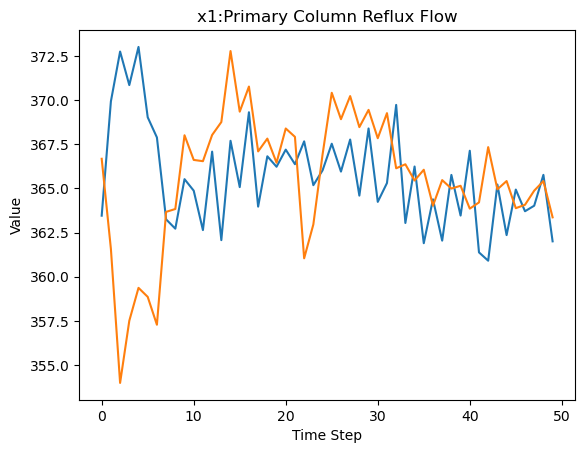

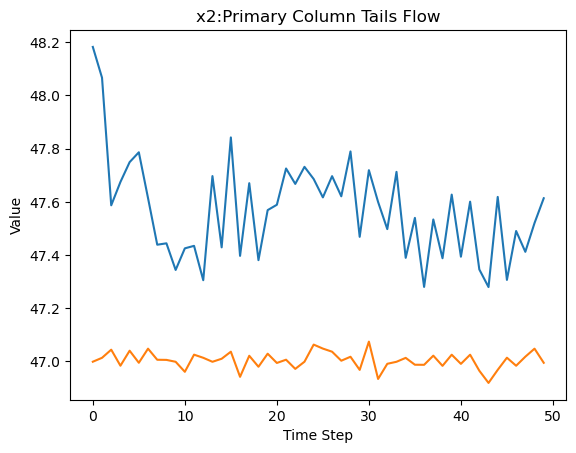

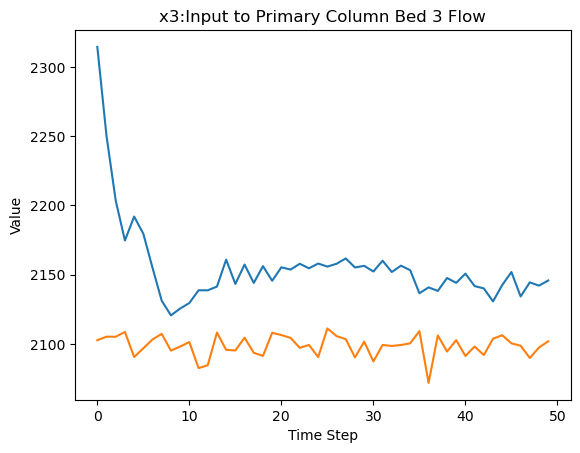

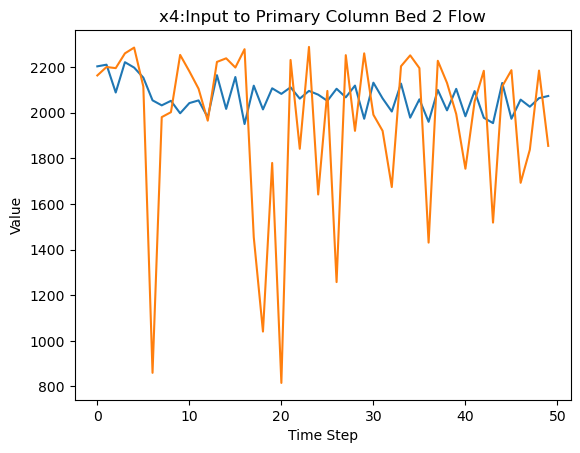

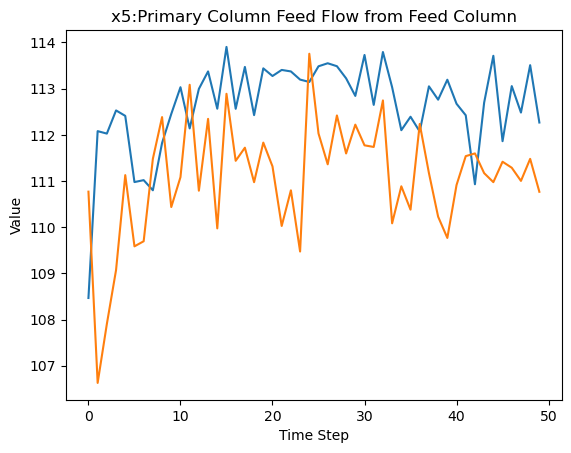

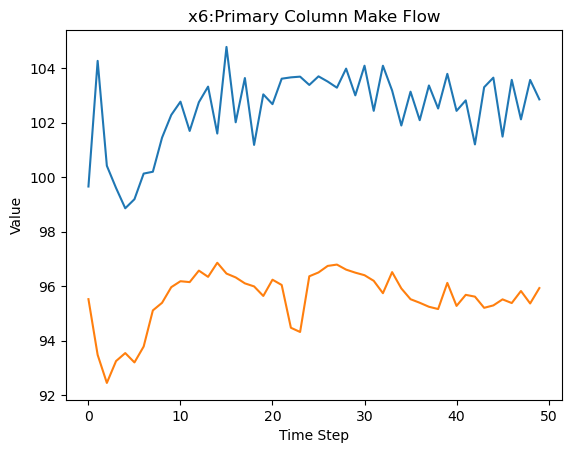

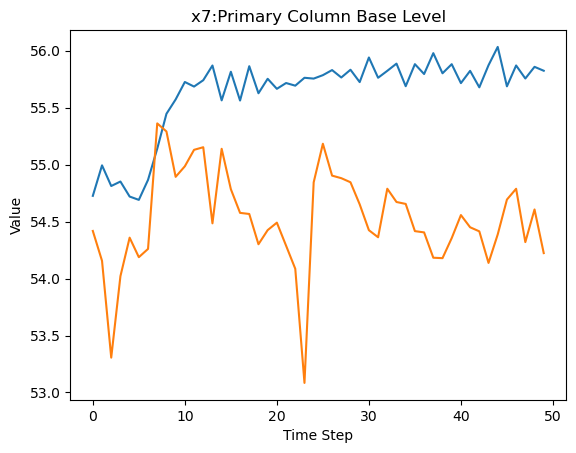

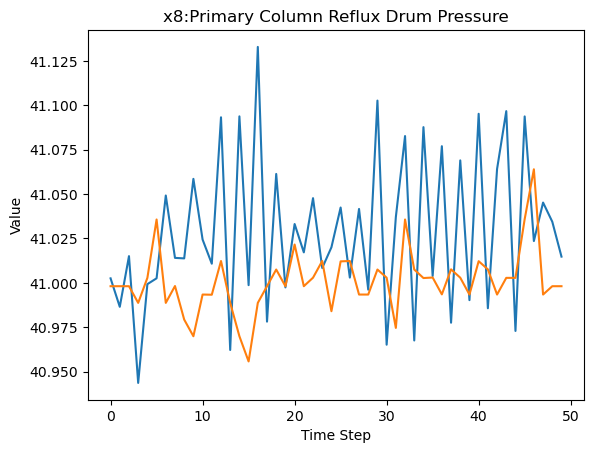

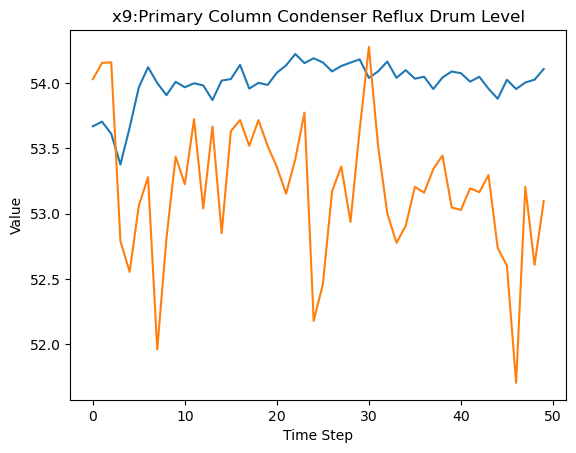

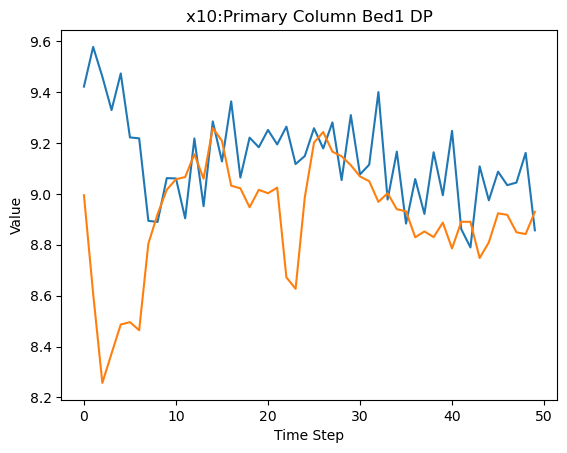

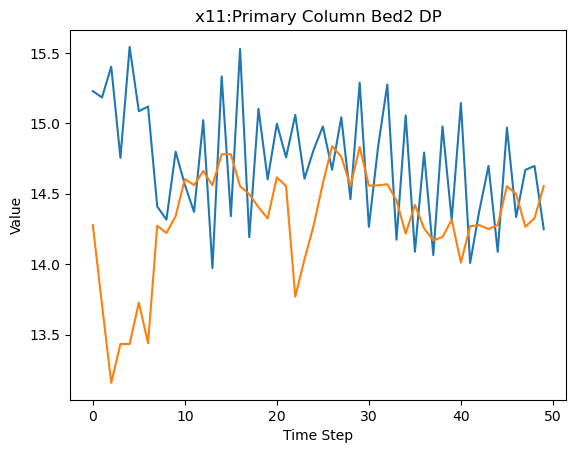

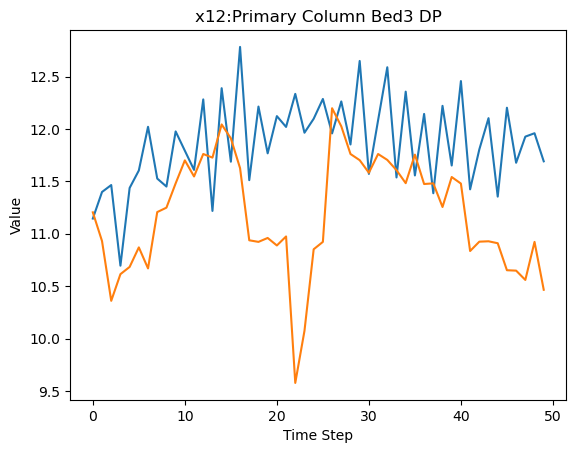

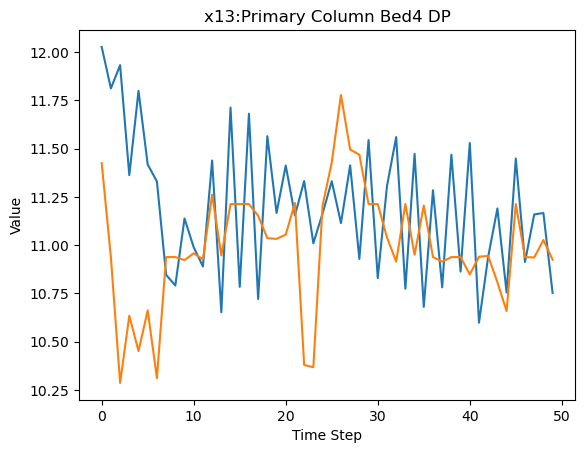

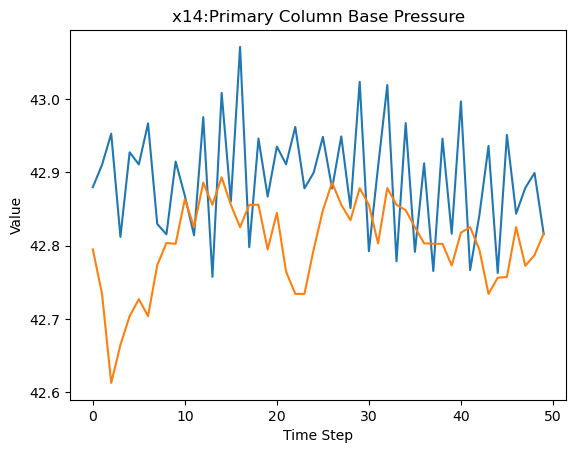

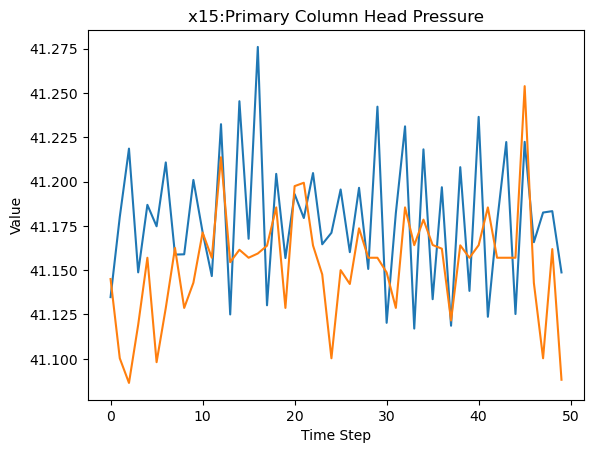

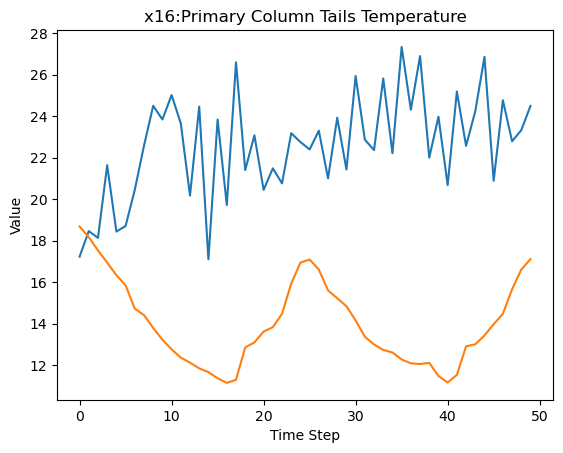

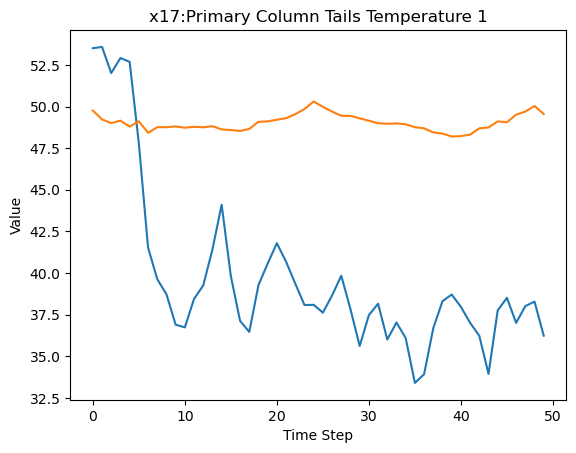

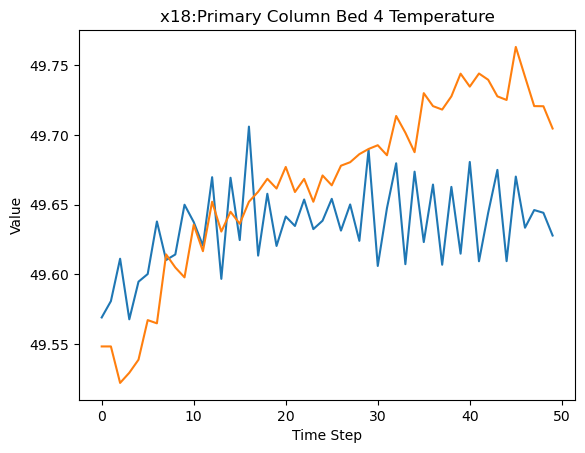

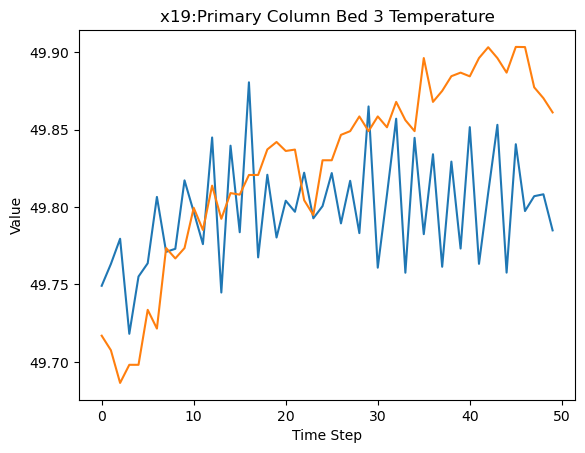

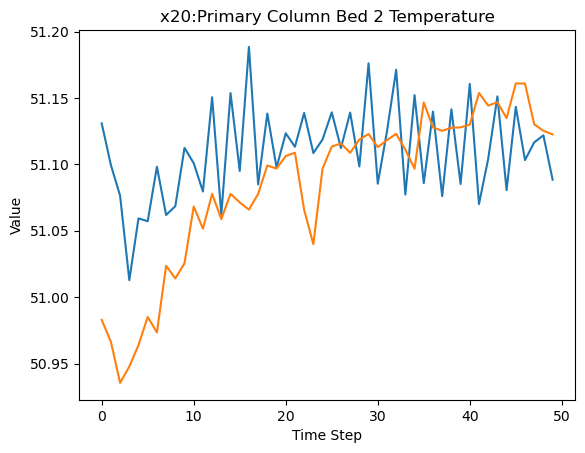

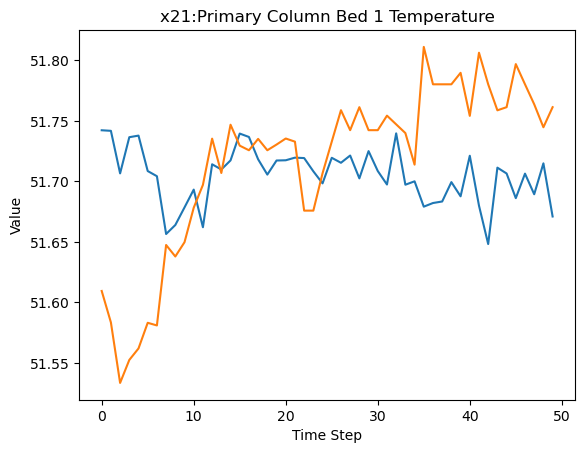

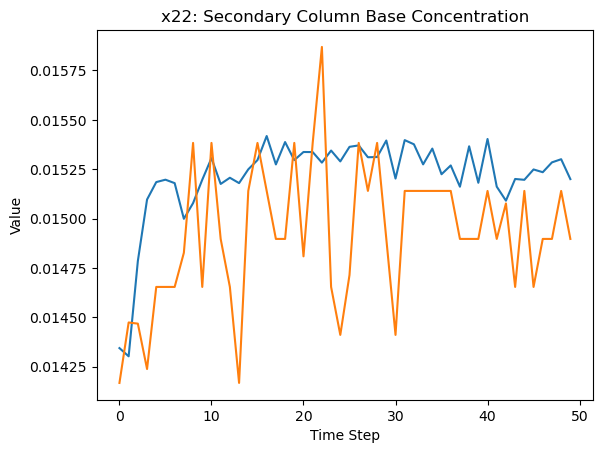

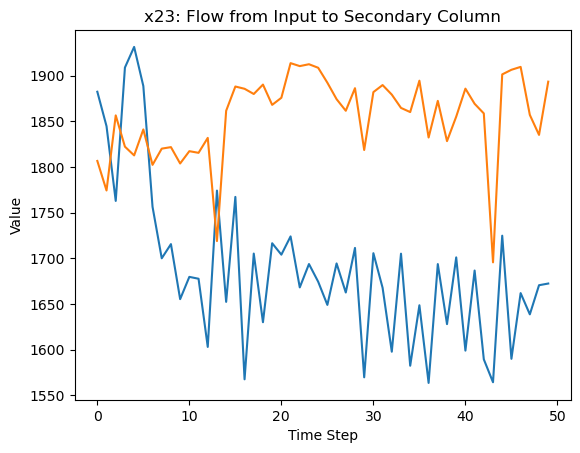

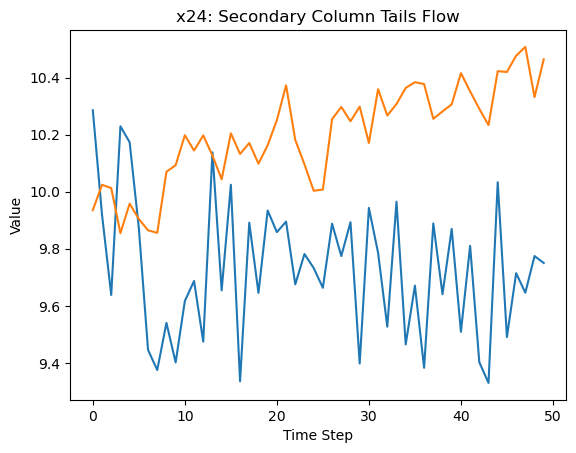

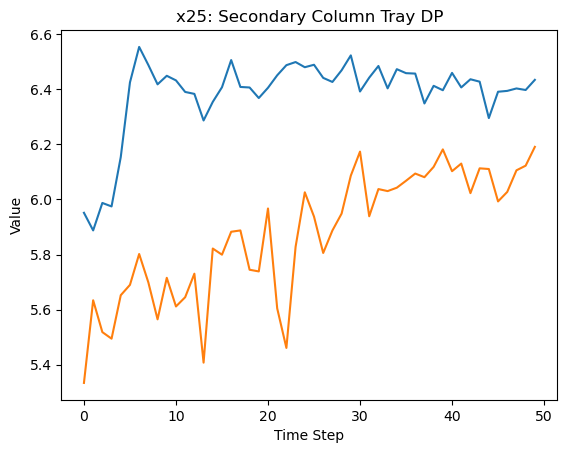

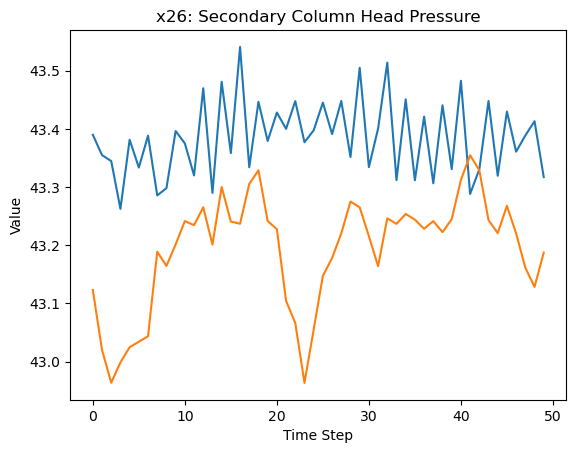

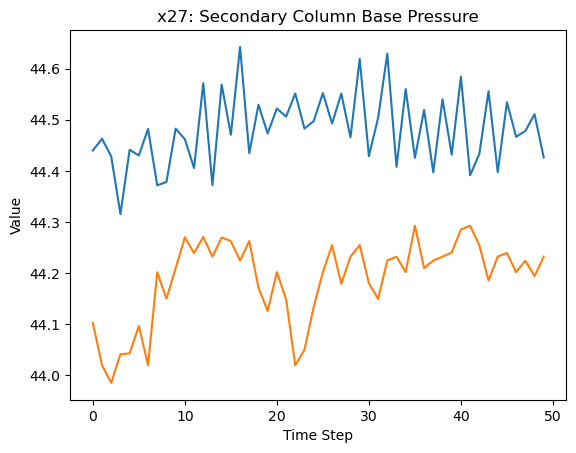

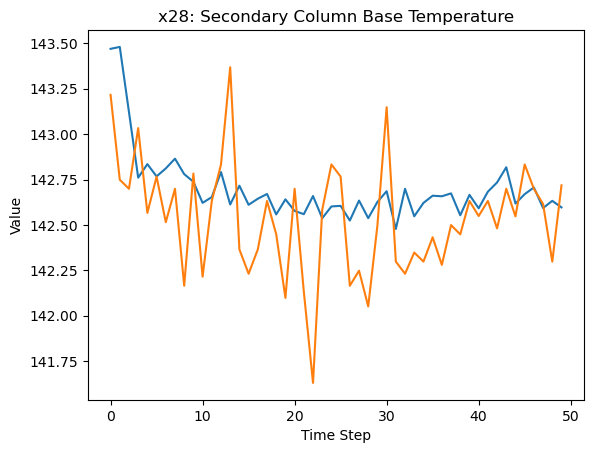

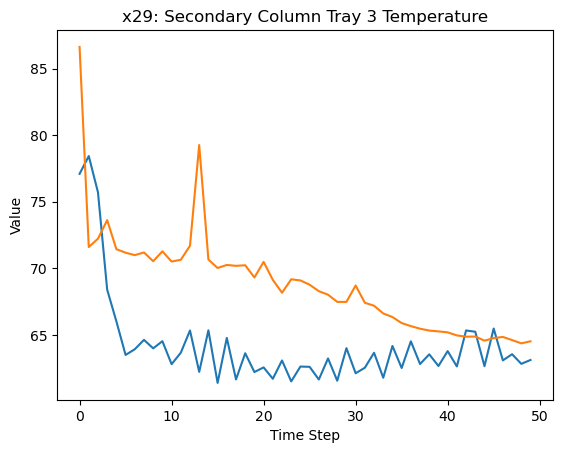

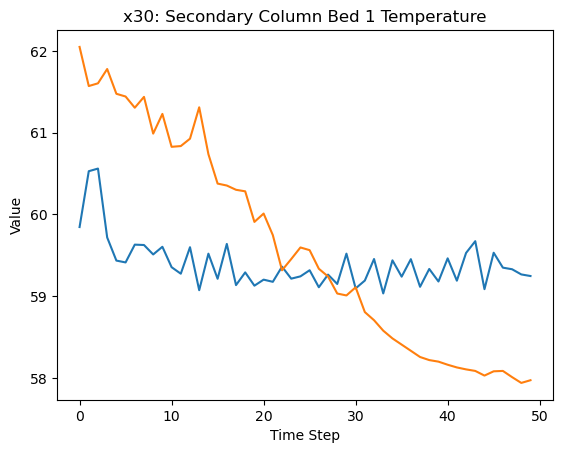

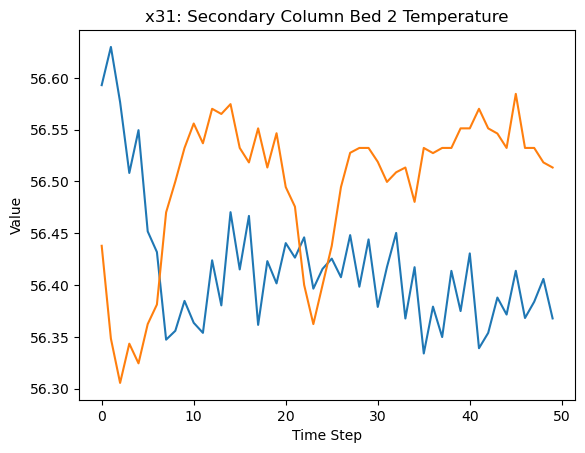

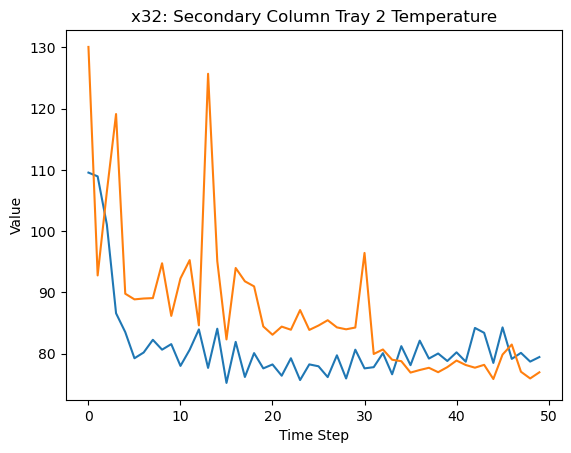

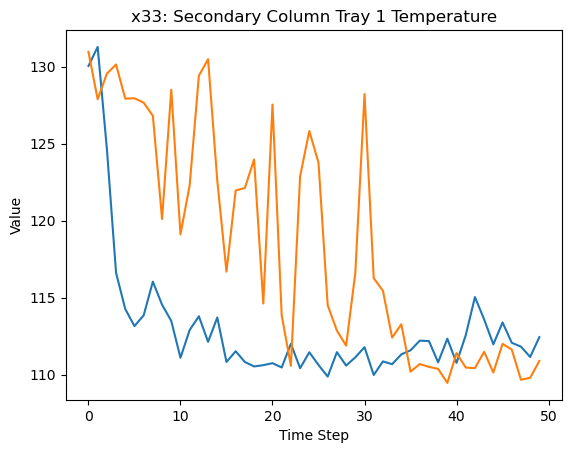

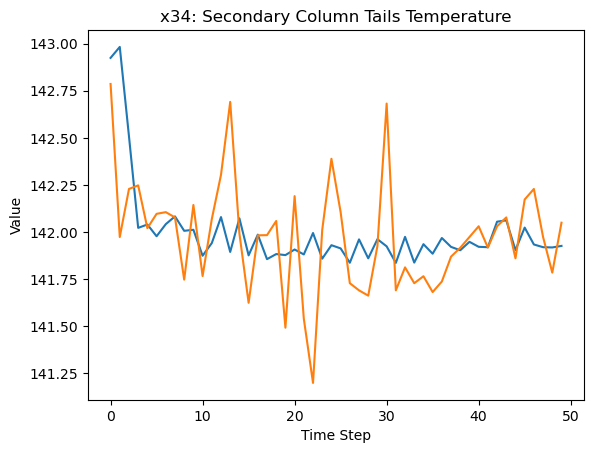

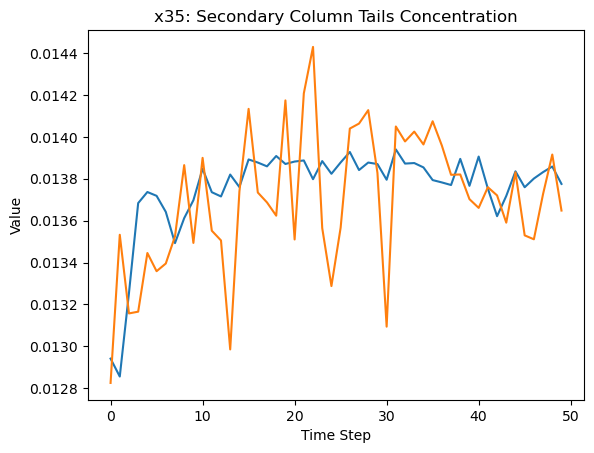

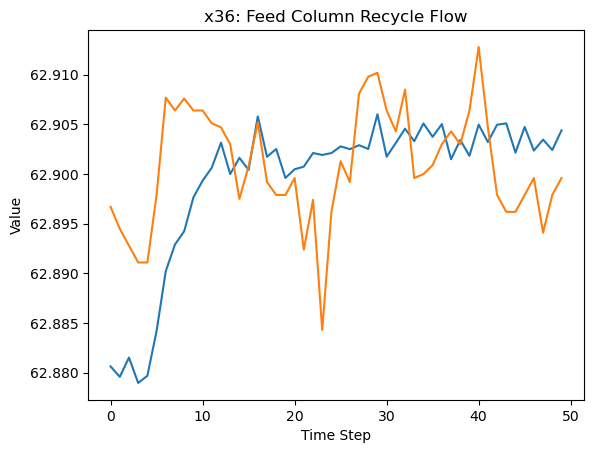

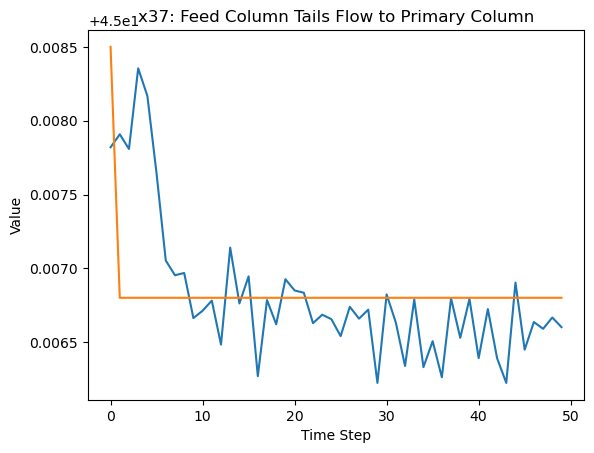

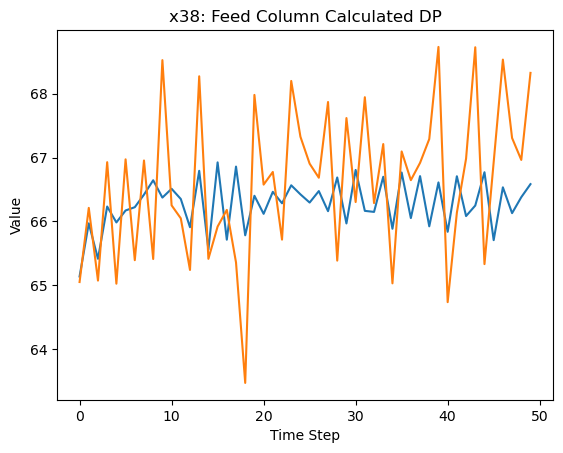

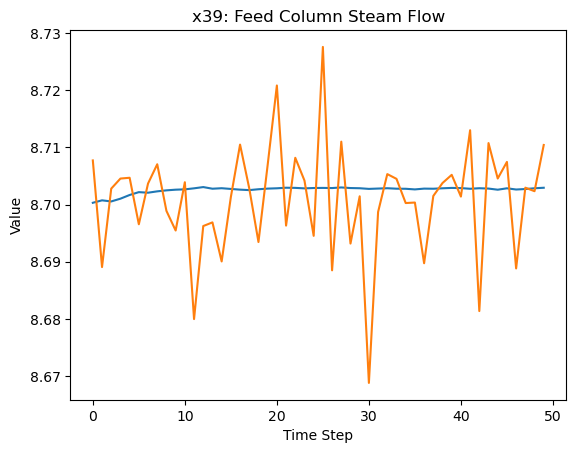

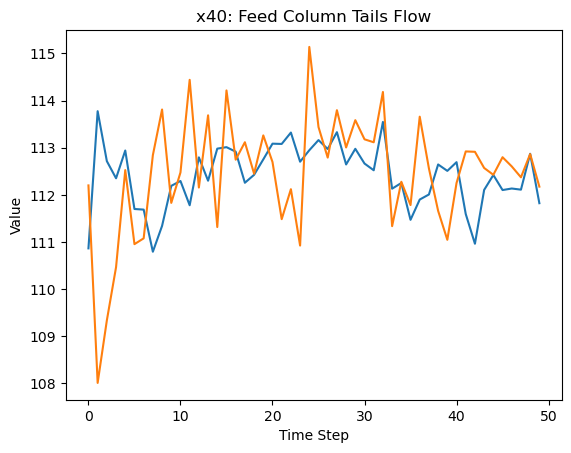

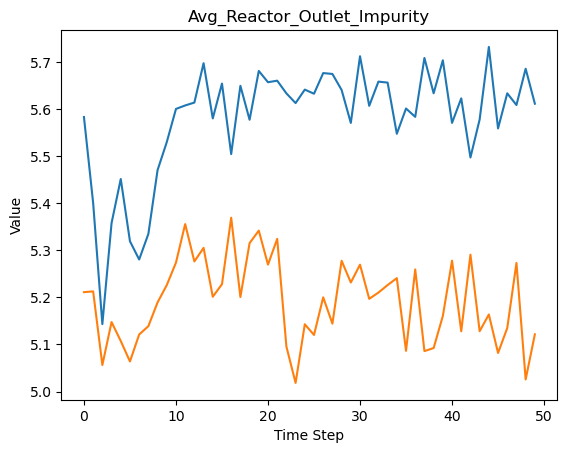

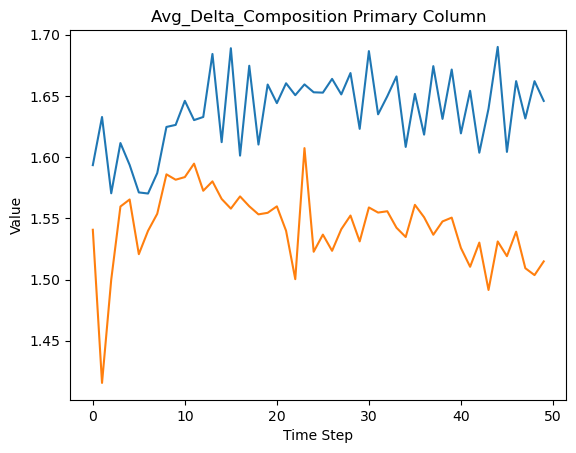

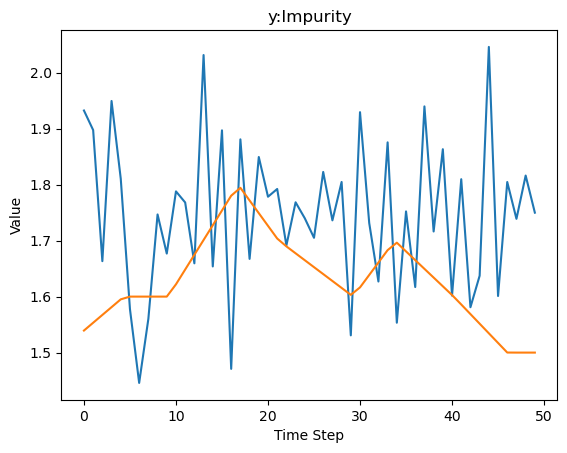

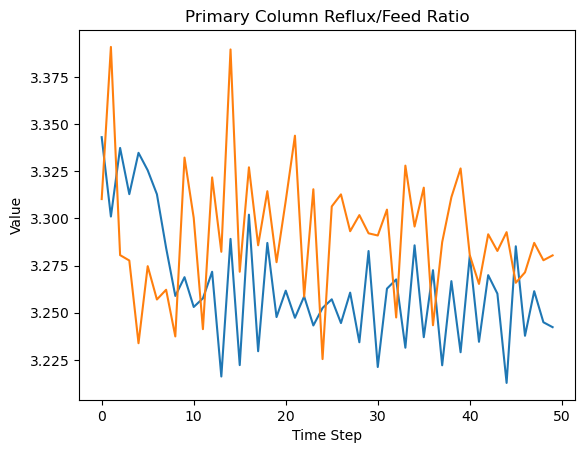

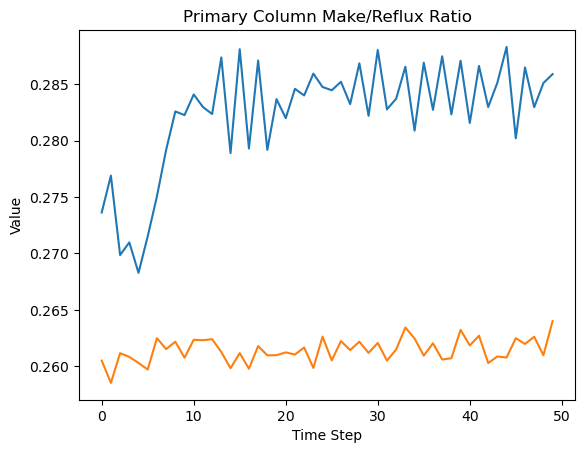

In [27]:
# Iterate over and plot each feature of the first sequence
for i in range(input_dim):
    plt.figure(i)
    plt.plot(recovered_sequences[:,i])
    plt.plot(test_data_inverse[:,i])
    plt.title(f'{column_names[i]}')  # Use column name as the title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
plt.show()


In [45]:
def generate_timeseries_sequences(generator, recovery_network, embedding_network, test_data, num_samples, seq_length, num_segments):
    # Empty list to hold the generated sequences
    generated_data = []

    # Process the initial test data tensor
    test_data_tensor = torch.from_numpy(test_data.values).unsqueeze(0).float()  
    condition = embedding_network(test_data_tensor)[:,0,:]

    # Loop over the number of segments
    for i in range(num_segments):
        # Generate a segment
        segment = generate_sequences(generator, recovery_network, num_samples, seq_length, condition)
        generated_data.append(segment)

        # Update the condition to be the last row of the previous input (condition)
#         condition = condition[-1, :].unsqueeze(0)
        # Update the condition to be the last row of the generated segment
        last_sample = segment[-1]
        last_sample_tensor = torch.from_numpy(last_sample).unsqueeze(0).float()
        encode = embedding_network(last_sample_tensor).unsqueeze(0).float()
        condition = encode[:,0,:]
    # Concatenate all the segments into one sequence
    generated_data = np.concatenate(generated_data)
    
    return generated_data


In [59]:
test_data = pd.DataFrame(target_2, columns = column_names).iloc[4600:5000]


In [60]:
num_segments = 4
seq_length = 100
generated_data = generate_timeseries_sequences(generator, recovery_network, embedding_network, test_data, num_samples, seq_length, num_segments)

C:\Users\16148\AppData\Local\Temp\ipykernel_7832\3047357923.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


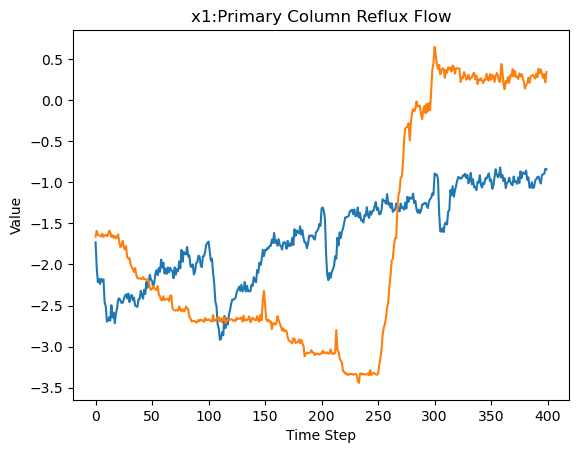

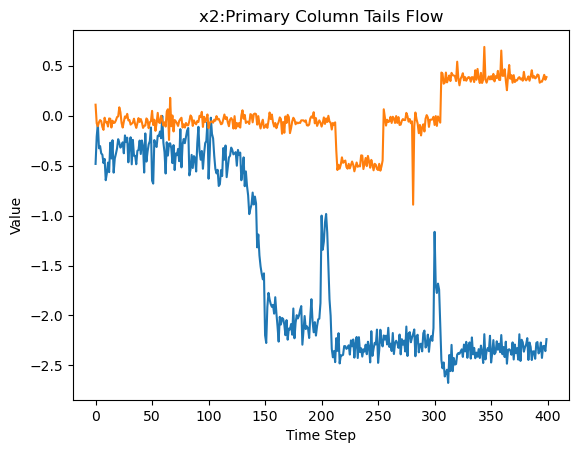

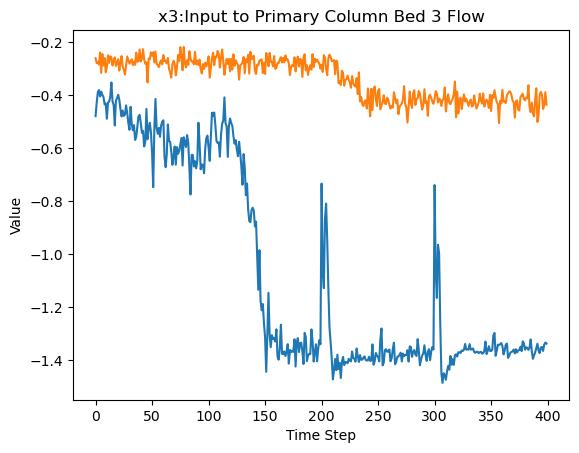

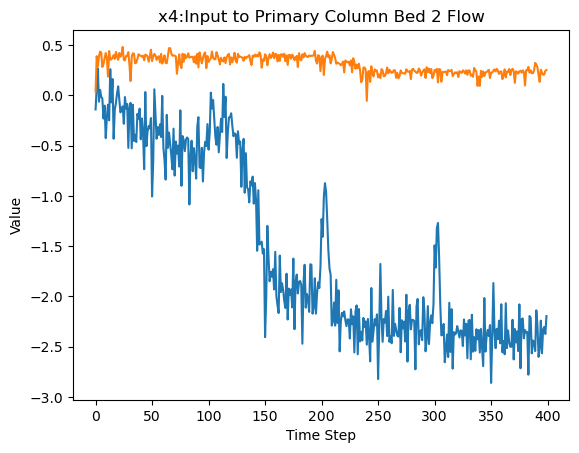

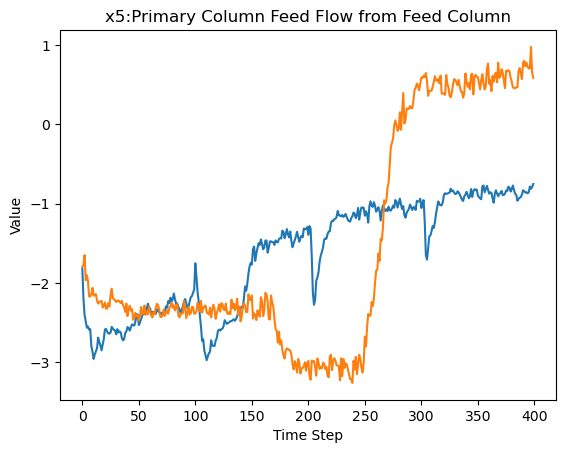

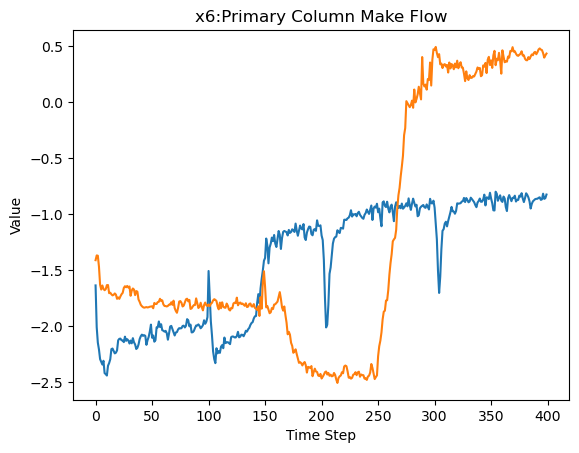

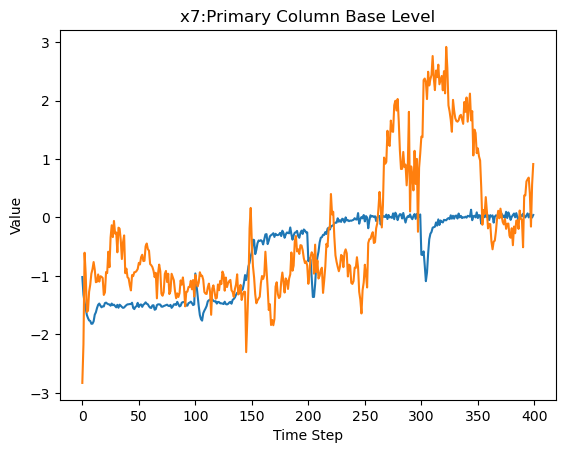

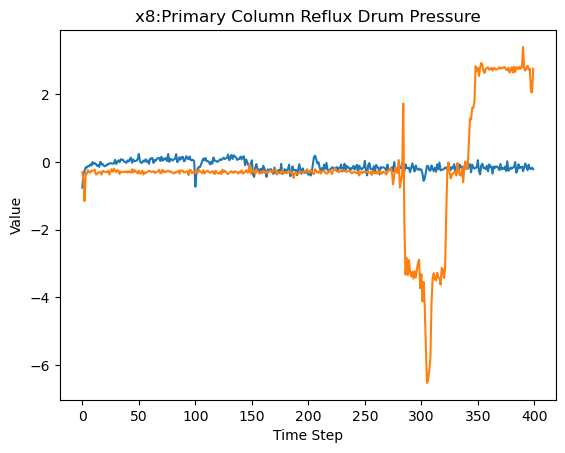

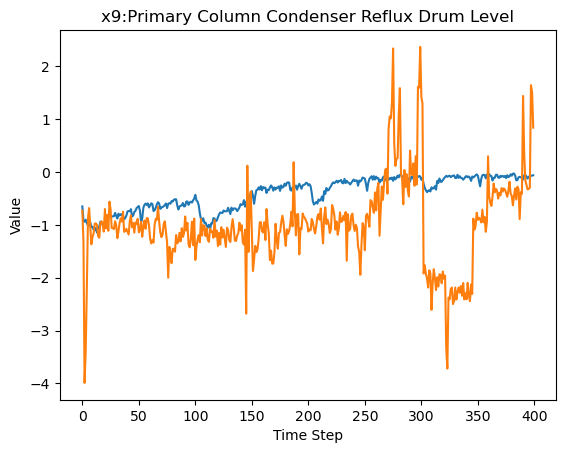

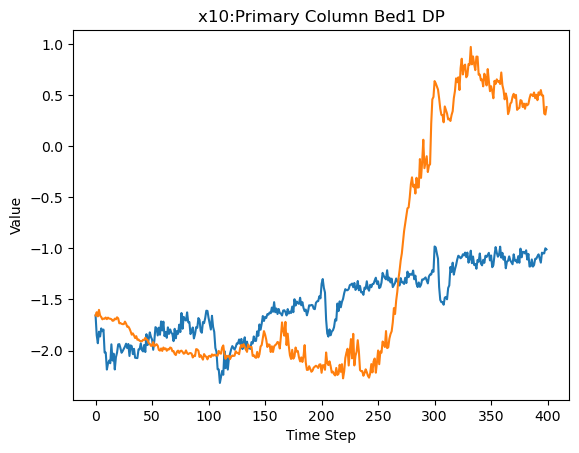

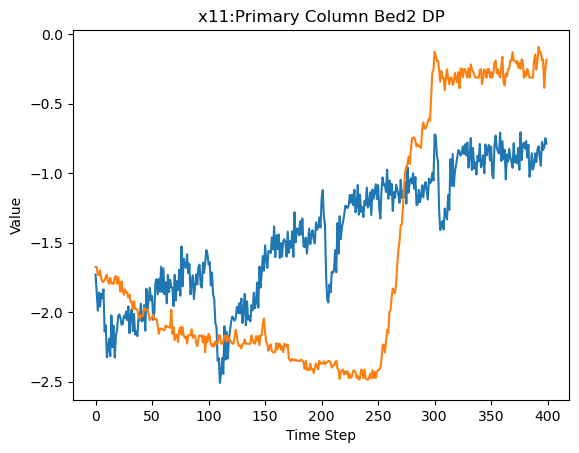

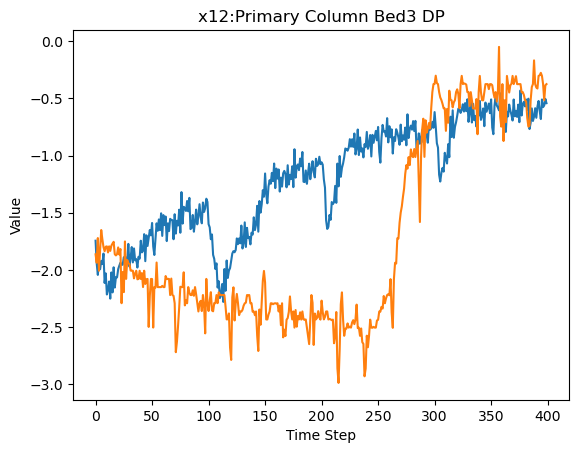

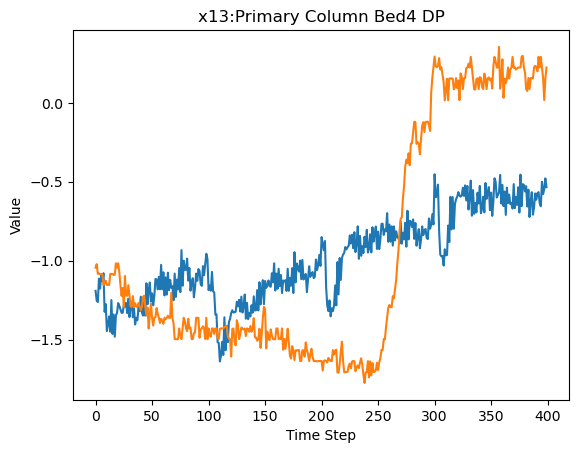

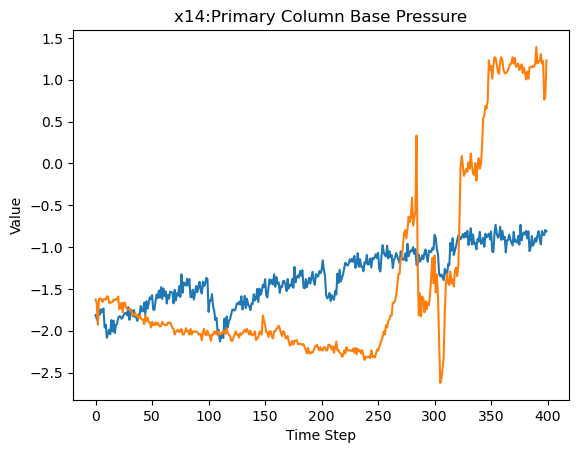

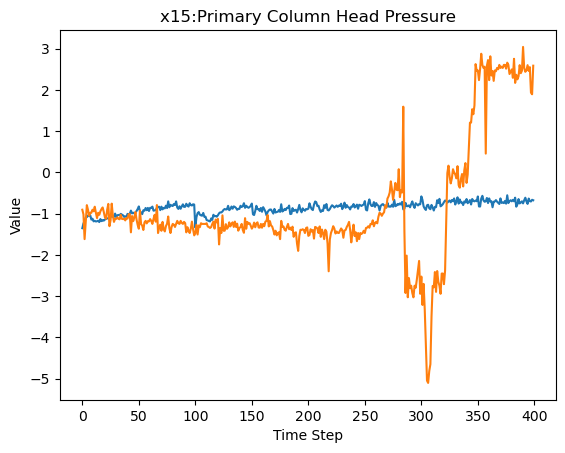

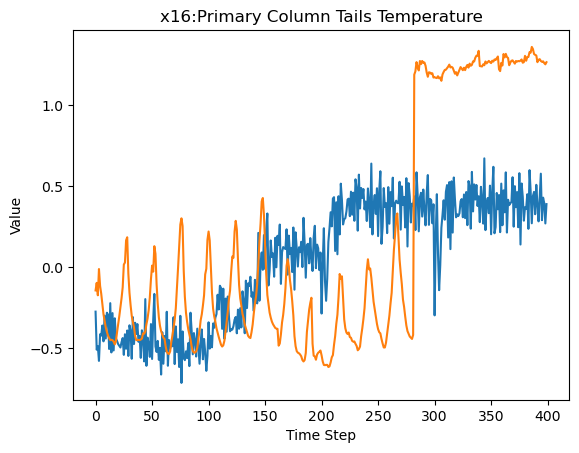

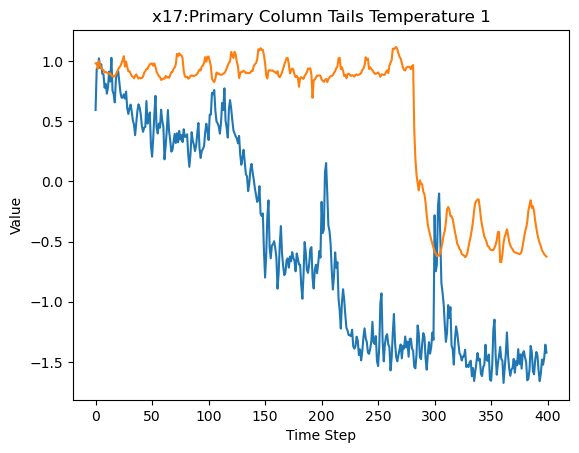

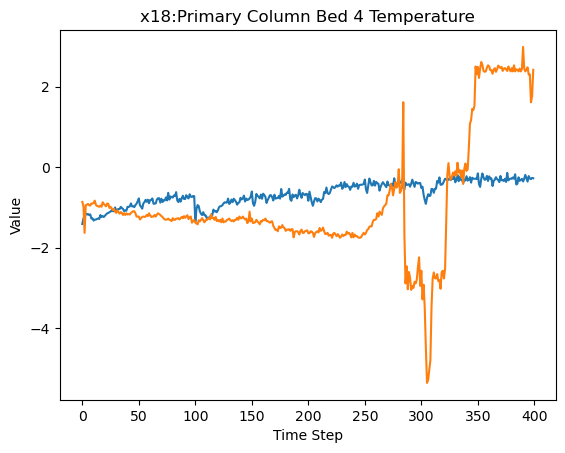

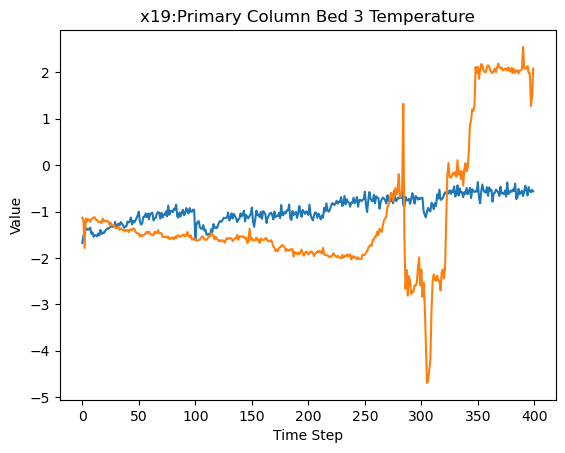

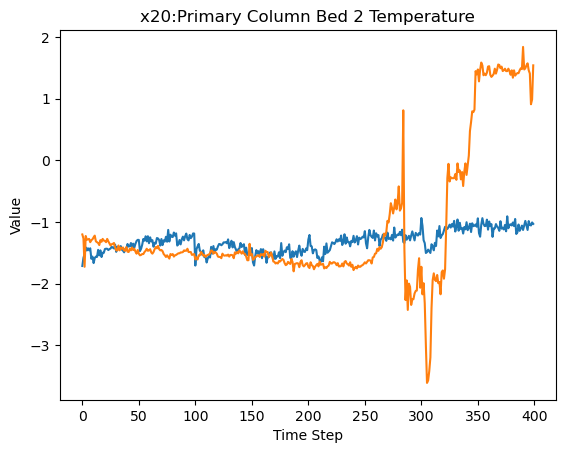

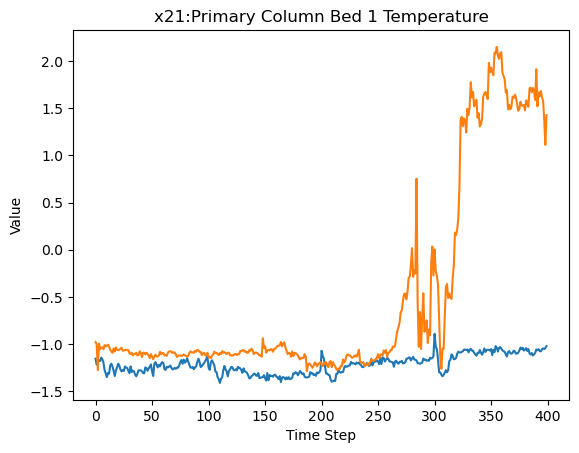

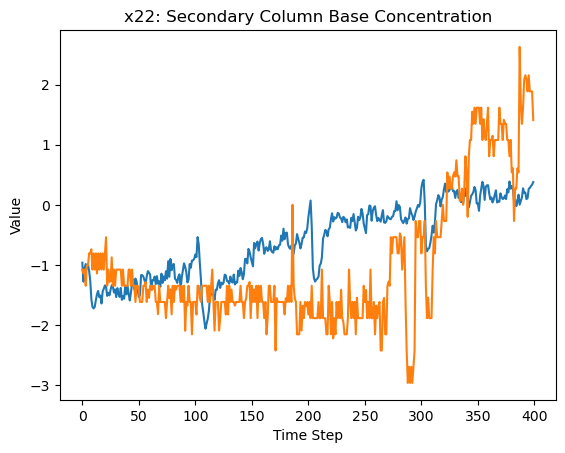

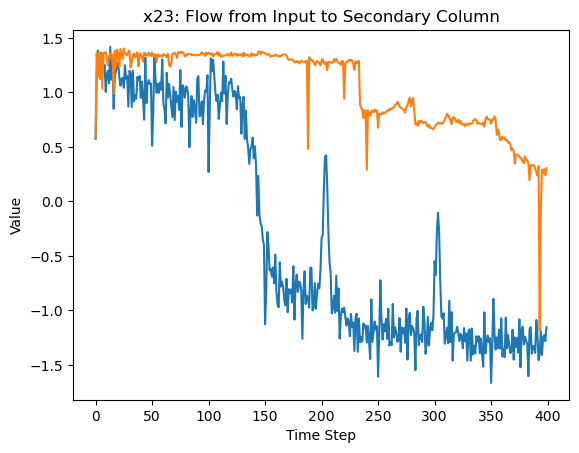

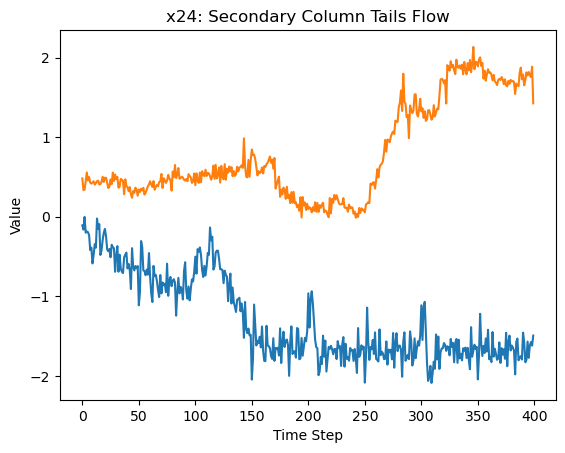

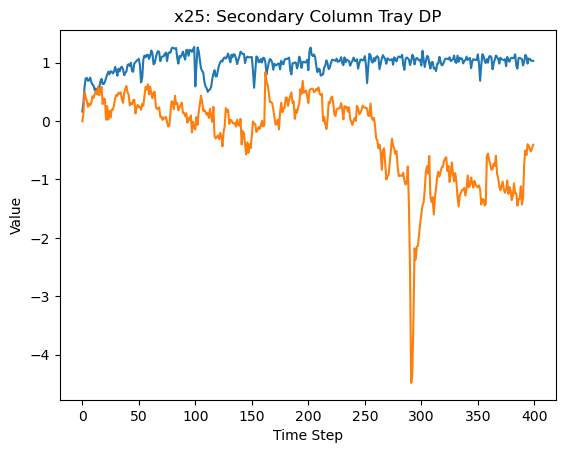

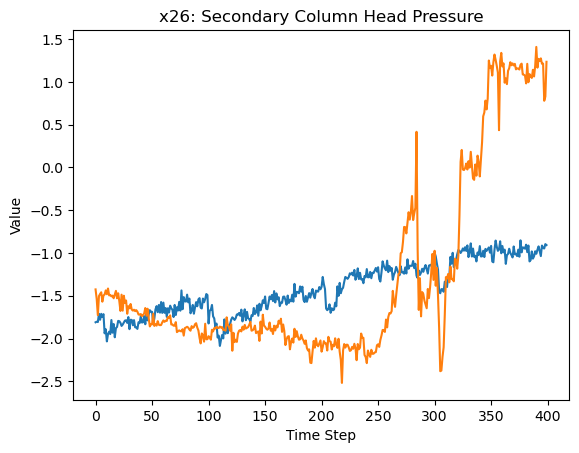

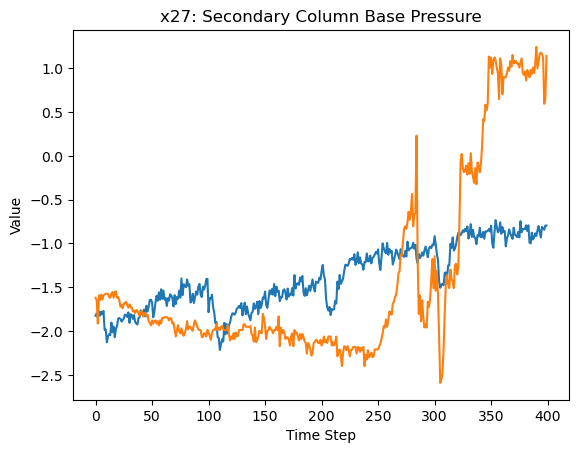

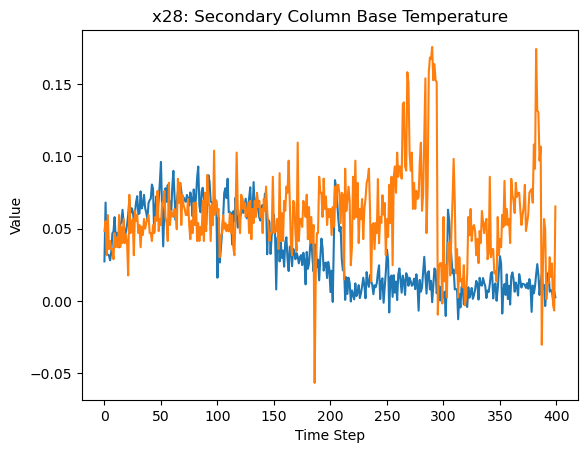

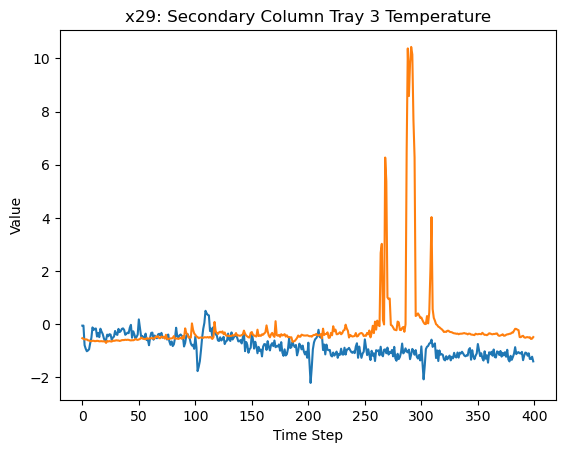

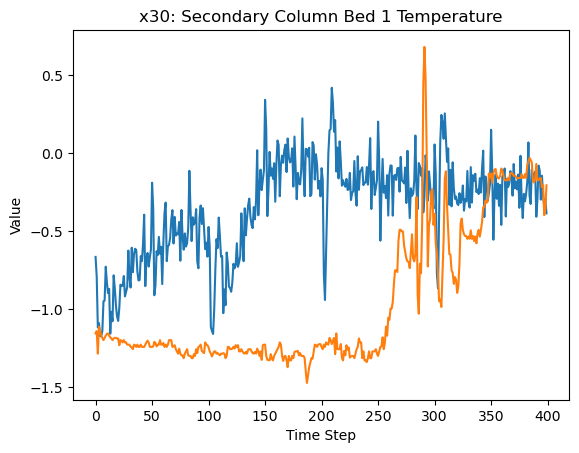

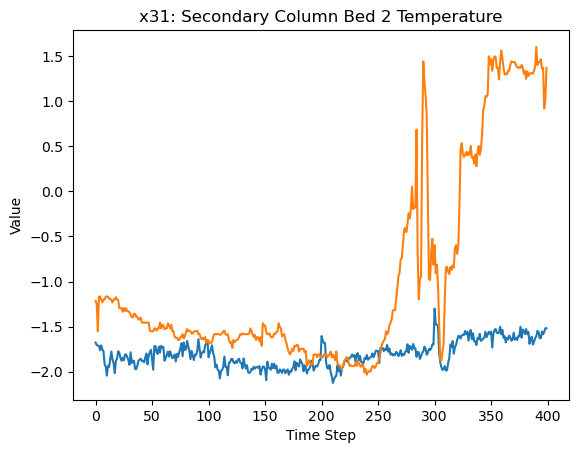

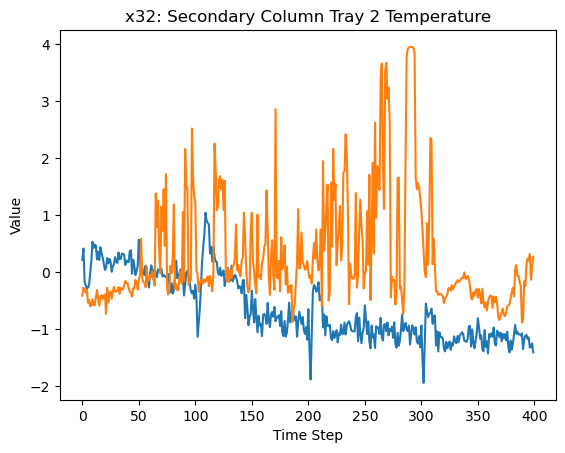

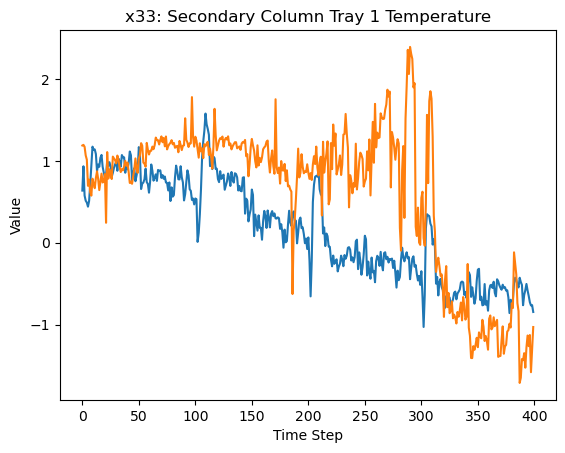

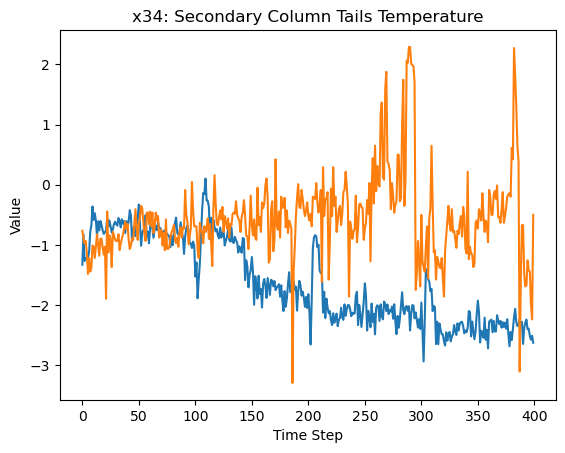

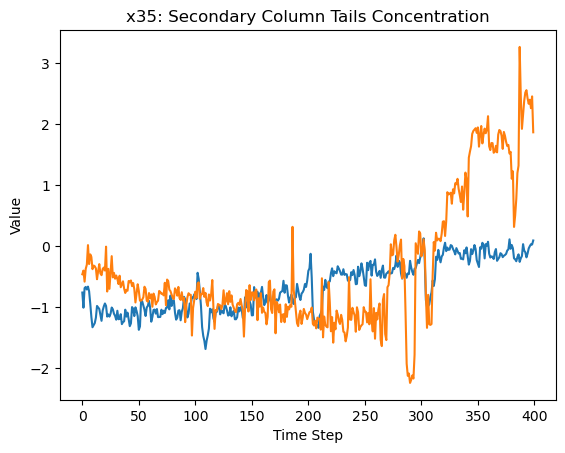

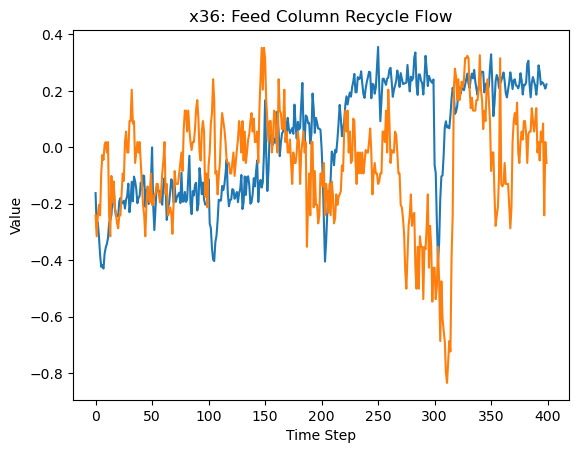

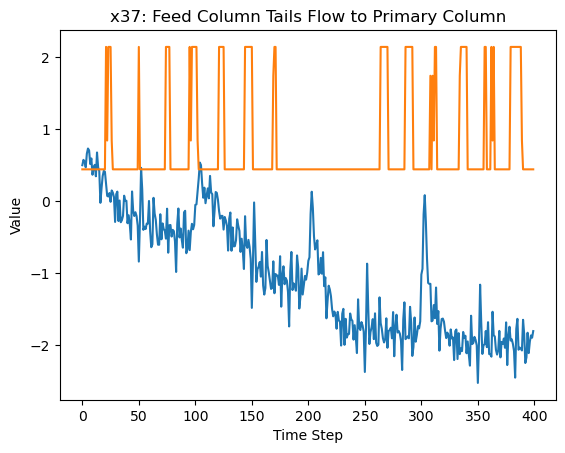

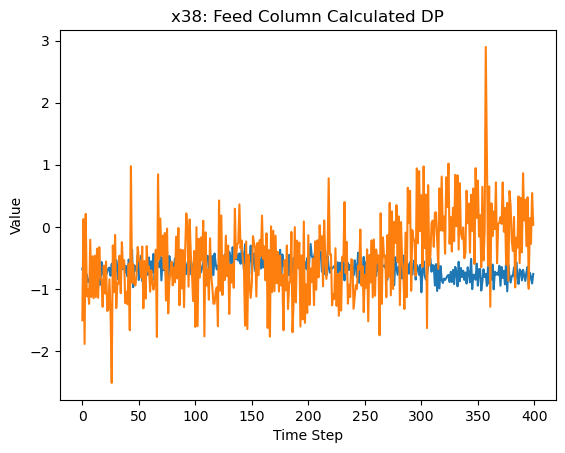

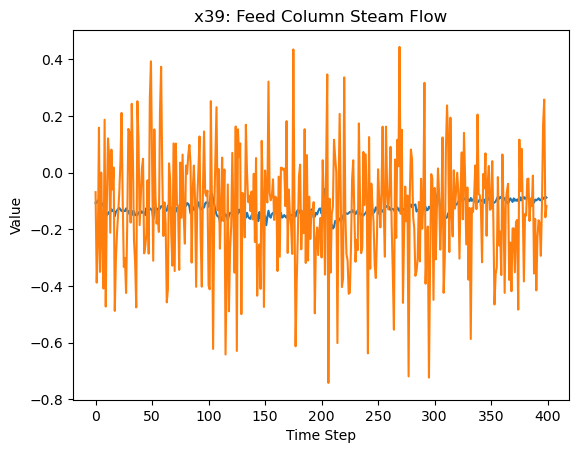

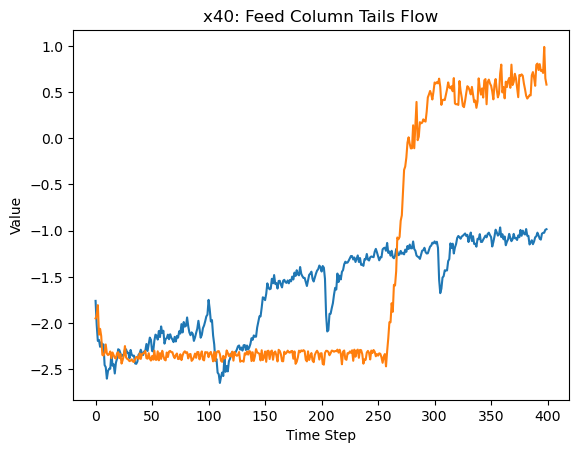

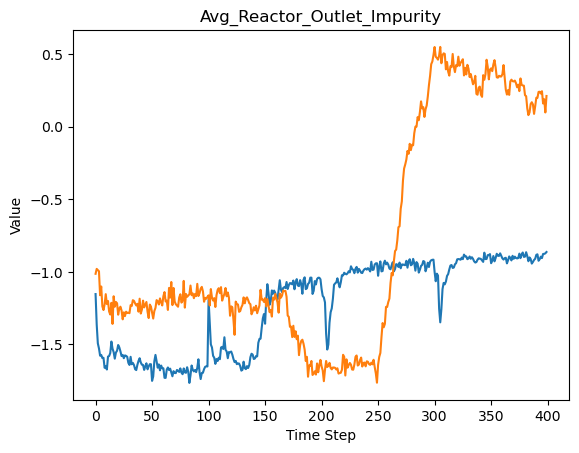

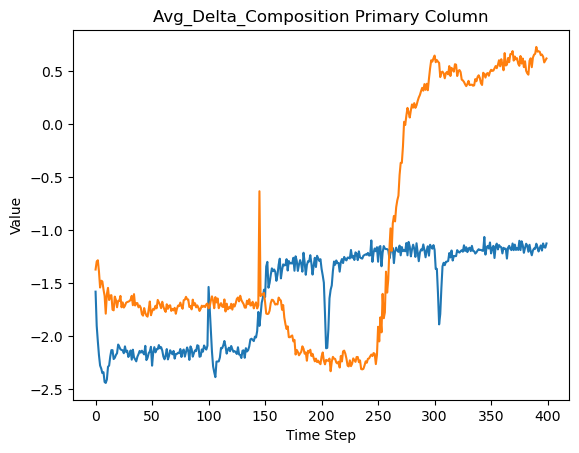

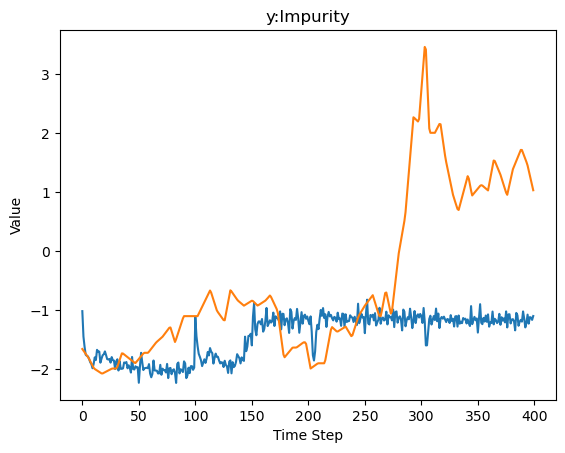

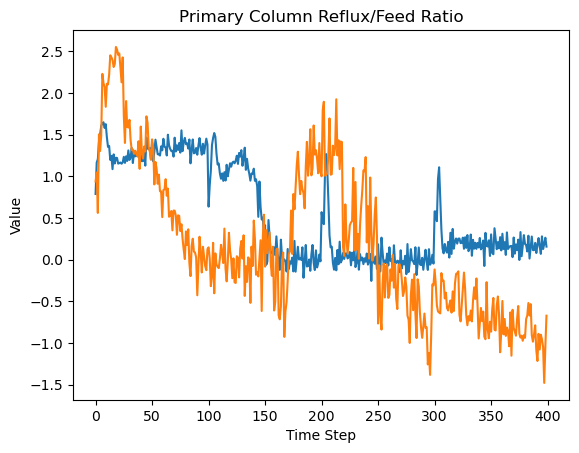

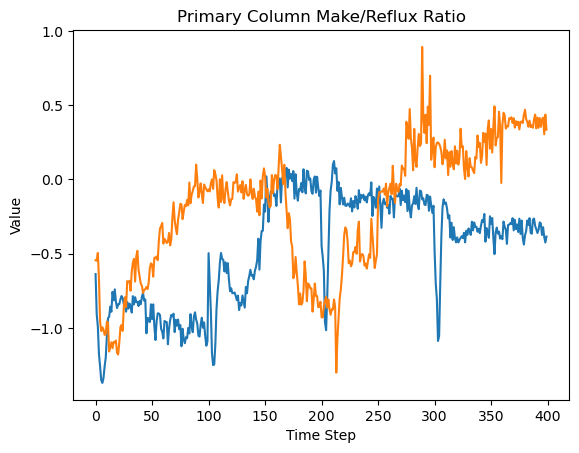

In [61]:
test_data = test_data.values
# Iterate over and plot each feature of the first sequence
for i in range(input_dim):
    plt.figure(i)
    plt.plot(generated_data[:,i])
    plt.plot(test_data[:,i])
    plt.title(f'{column_names[i]}')  # Use column name as the title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
plt.show()

In [62]:
def generate_timeseries_sequences(generator, recovery_network, embedding_network, test_data, num_samples, seq_length):
    # Empty list to hold the generated sequences
    generated_data = []

    # Number of segments based on the length of the test data
    num_segments = len(test_data) // seq_length

    # Loop over the number of segments
    for i in range(num_segments):
        # Extract the condition from the test data at intervals of seq_length
        test_data_segment = test_data[i*seq_length:(i+1)*seq_length]
        test_data_tensor = torch.from_numpy(test_data_segment.values).unsqueeze(0).float()  
        condition = embedding_network(test_data_tensor)[:,0,:]

        # Generate a segment
        segment = generate_sequences(generator, recovery_network, num_samples, seq_length, condition)
        generated_data.append(segment)

    # Concatenate all the segments into one sequence
    generated_data = np.concatenate(generated_data)

    return generated_data


In [64]:
test_data = pd.DataFrame(target_2, columns = column_names).iloc[4600:5000]
num_segments = 4
seq_length = 100
generated_data = generate_timeseries_sequences(generator, recovery_network, embedding_network, test_data, num_samples, seq_length)

C:\Users\16148\AppData\Local\Temp\ipykernel_7832\3047357923.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


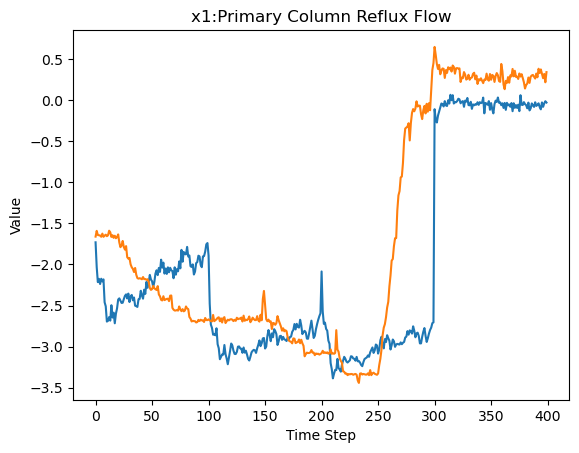

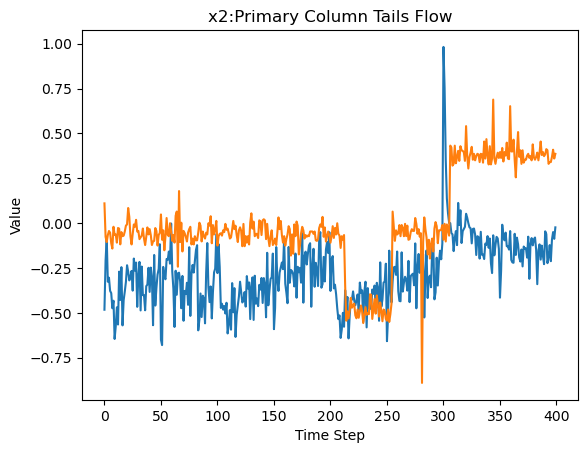

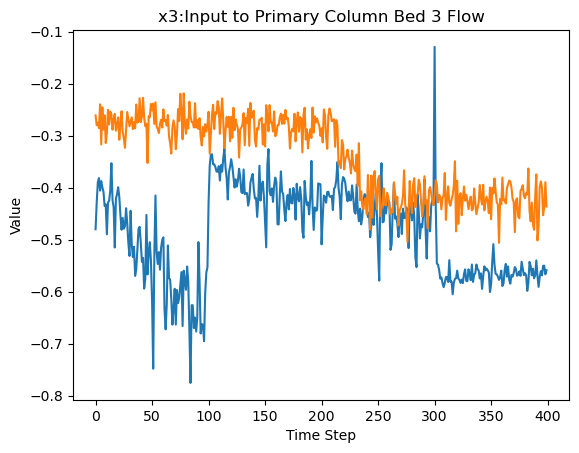

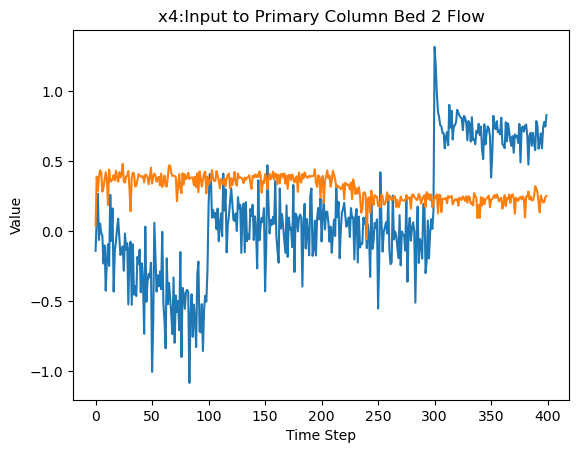

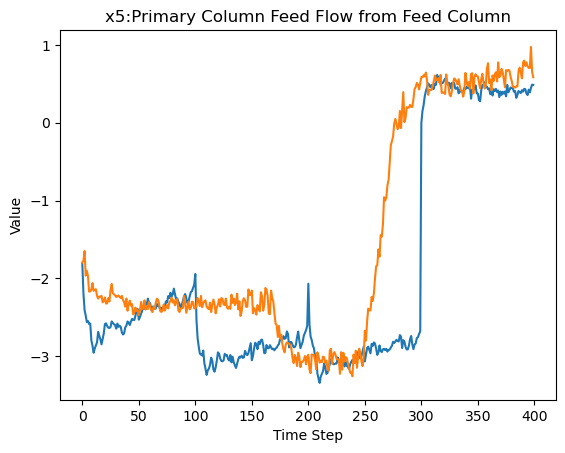

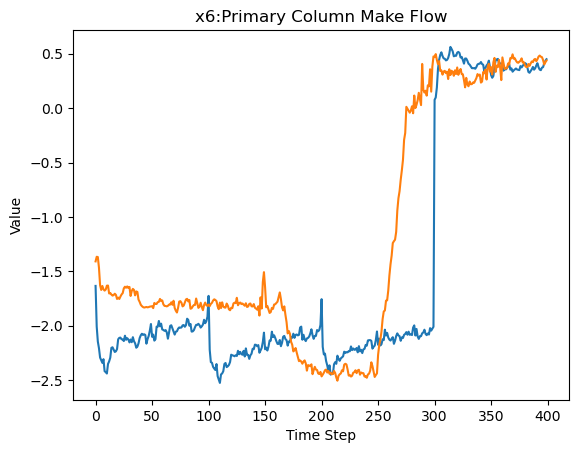

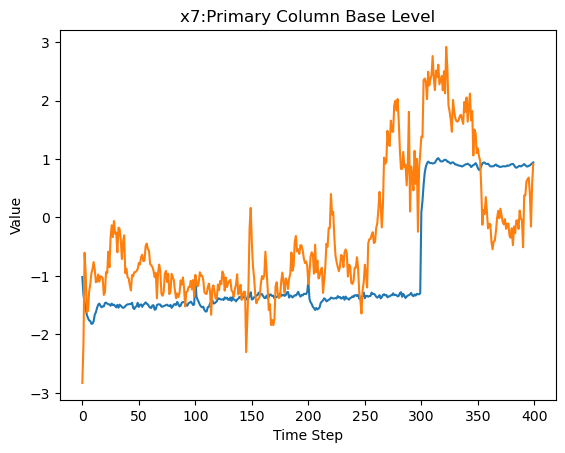

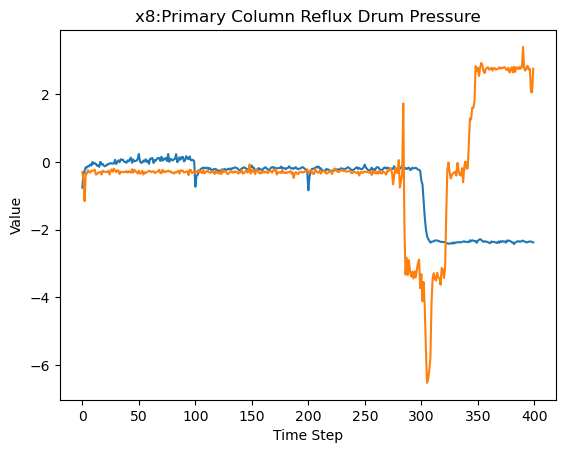

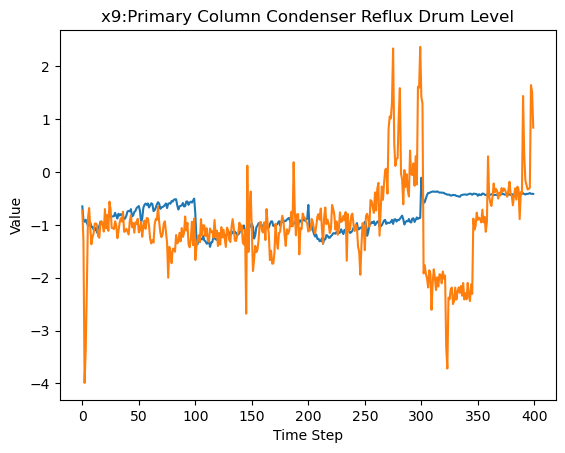

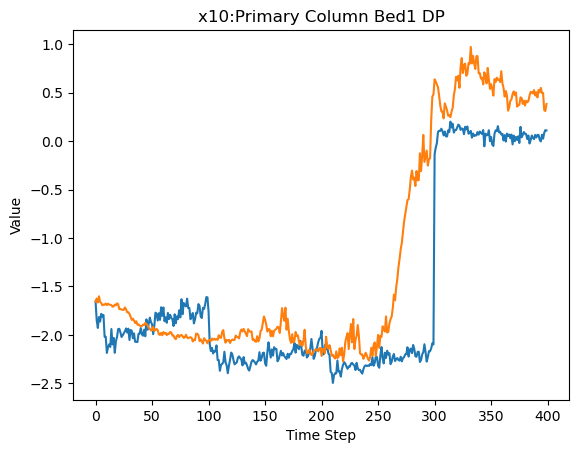

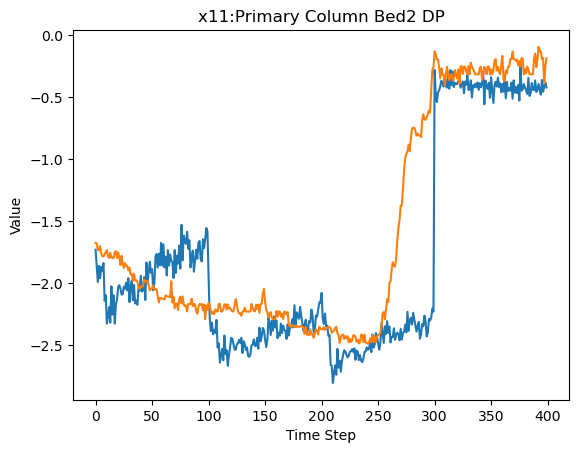

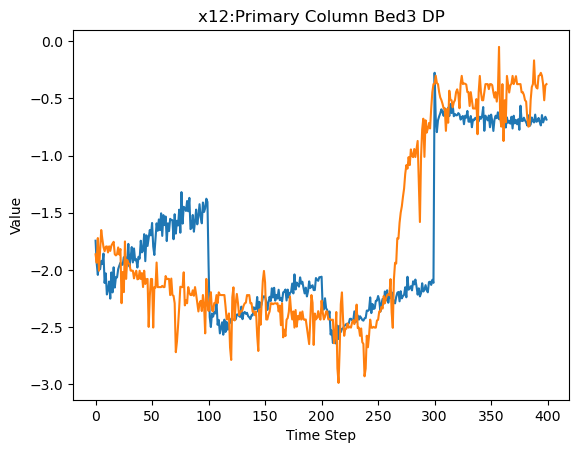

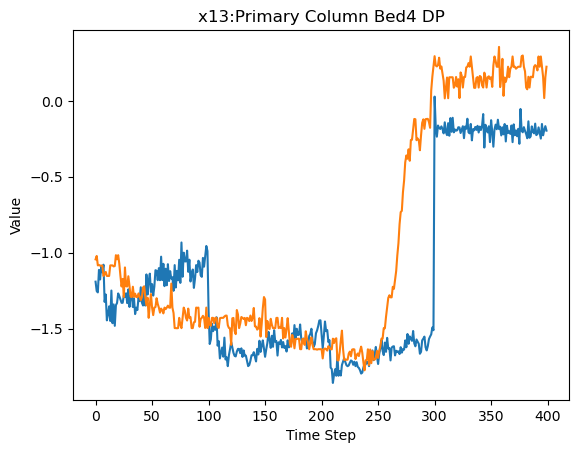

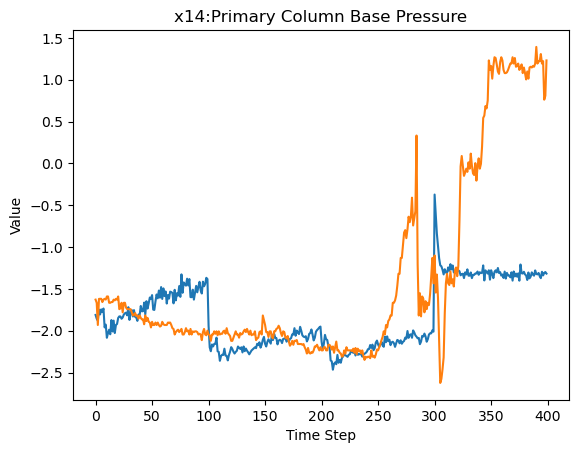

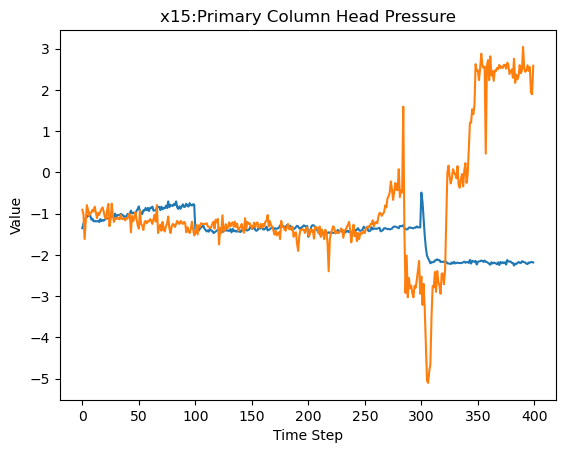

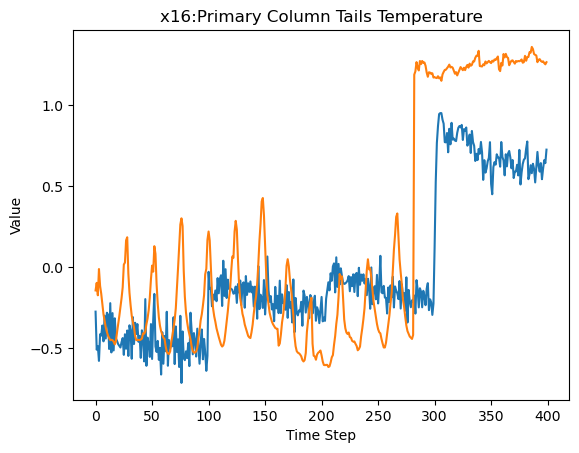

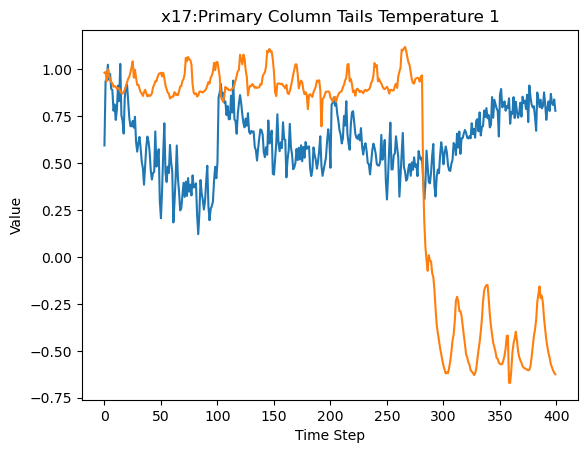

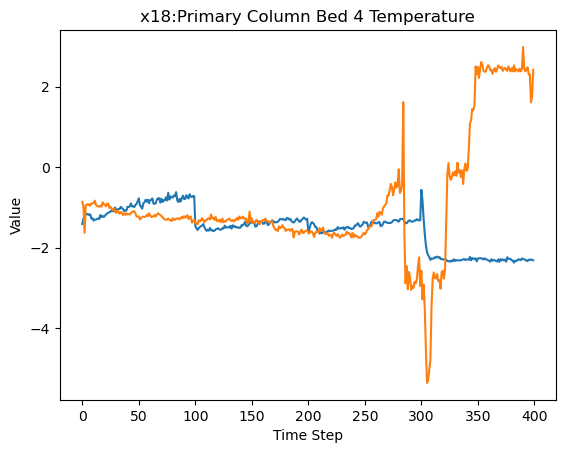

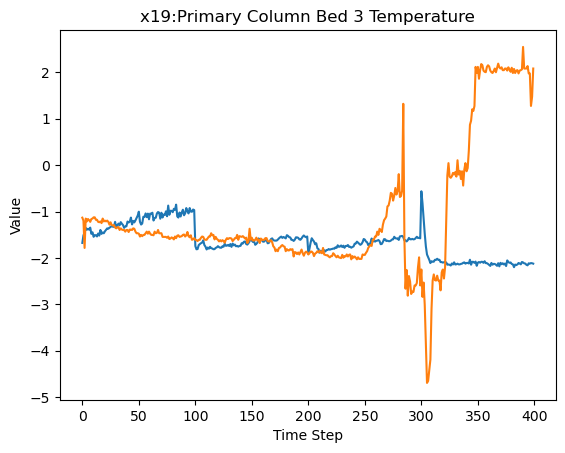

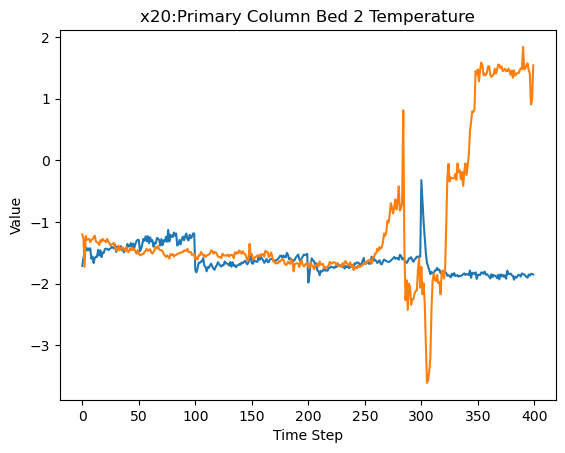

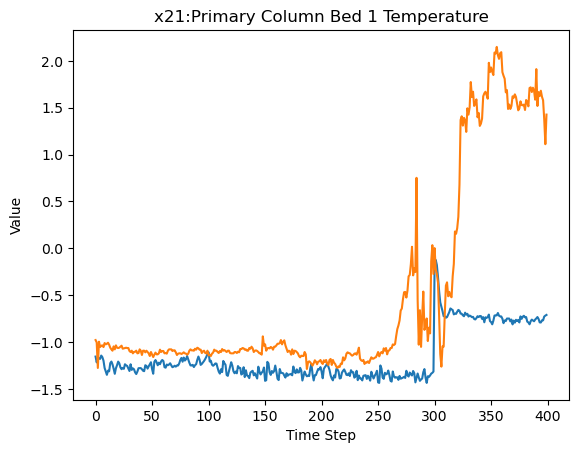

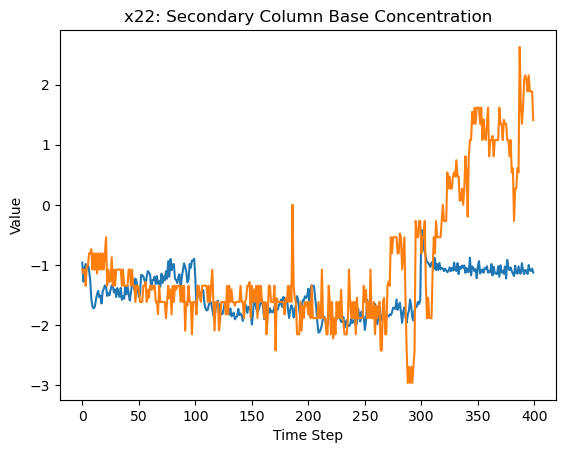

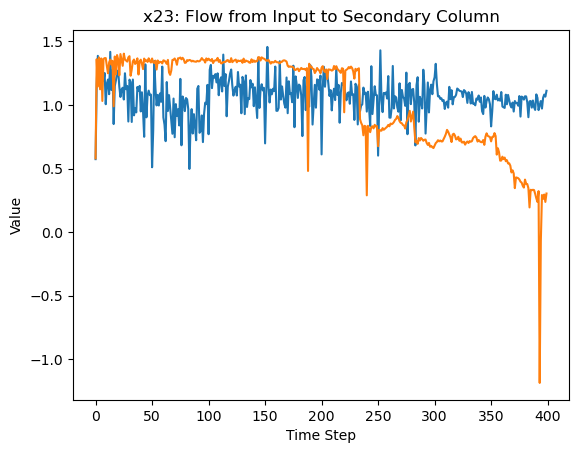

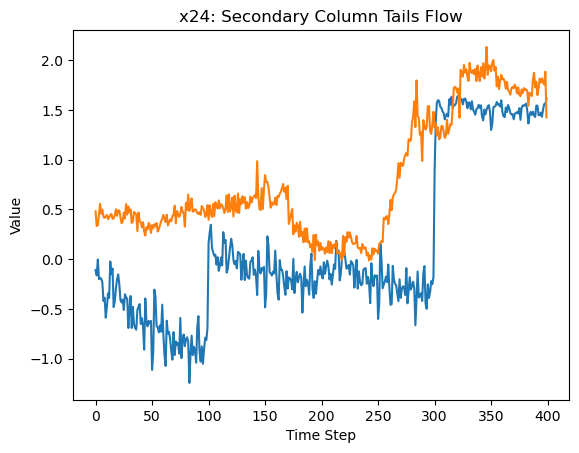

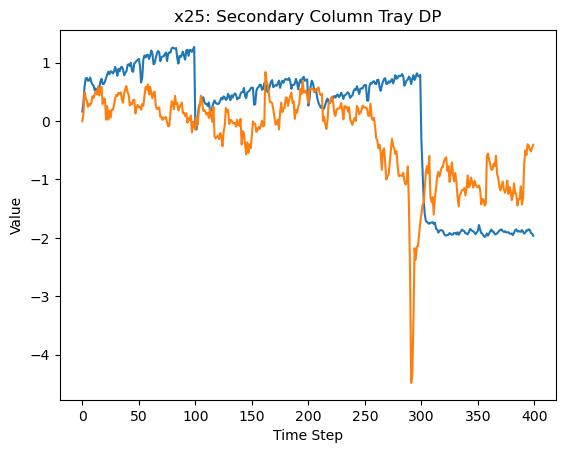

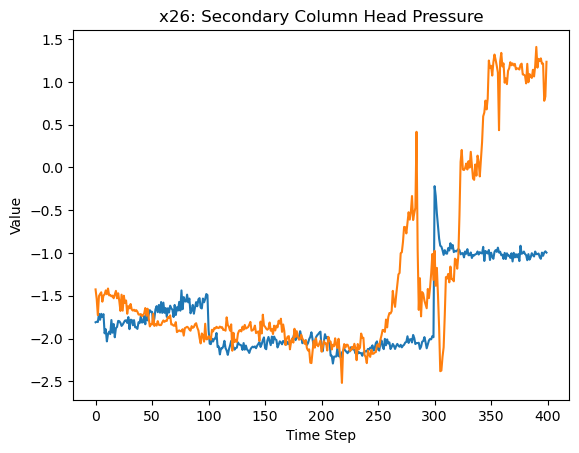

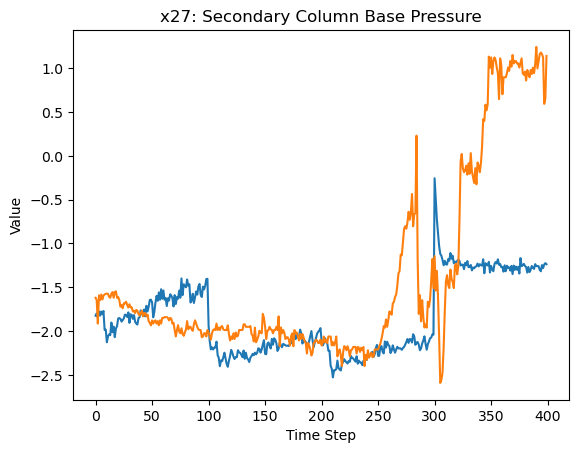

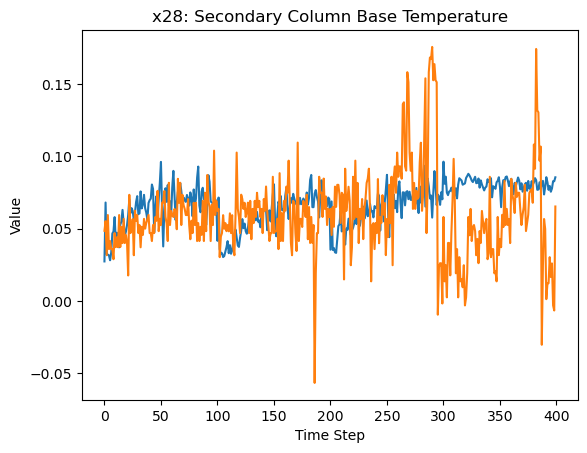

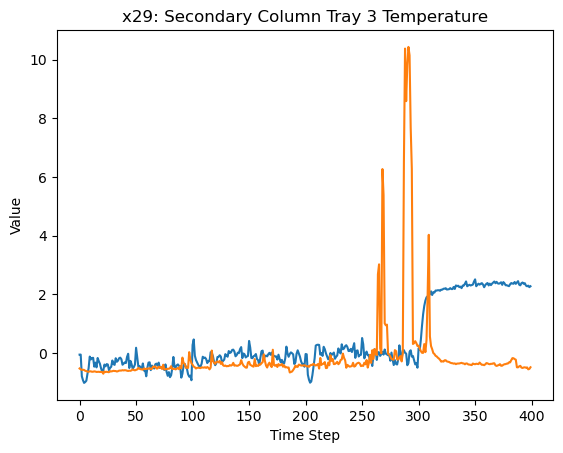

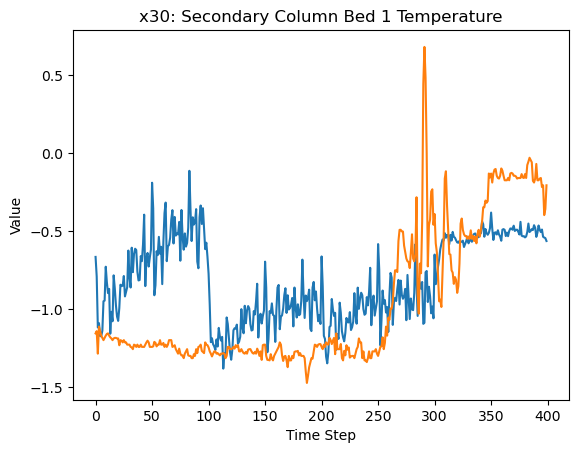

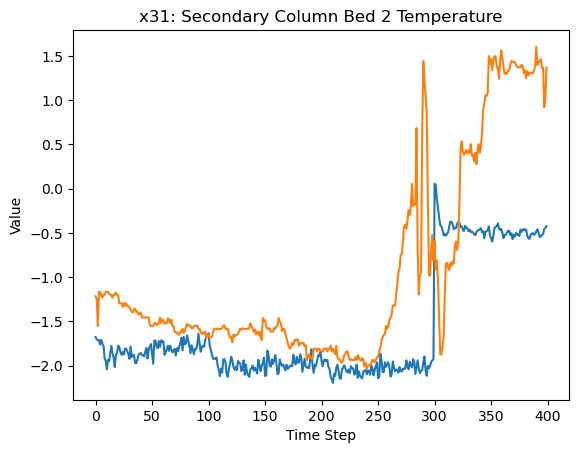

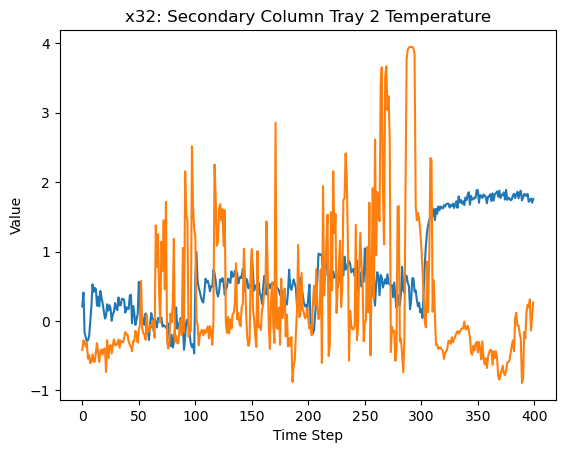

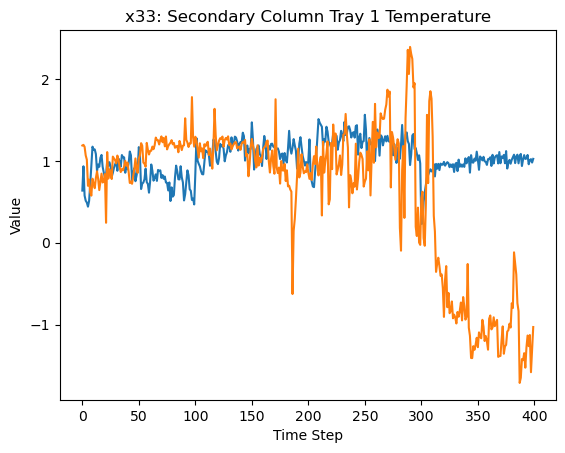

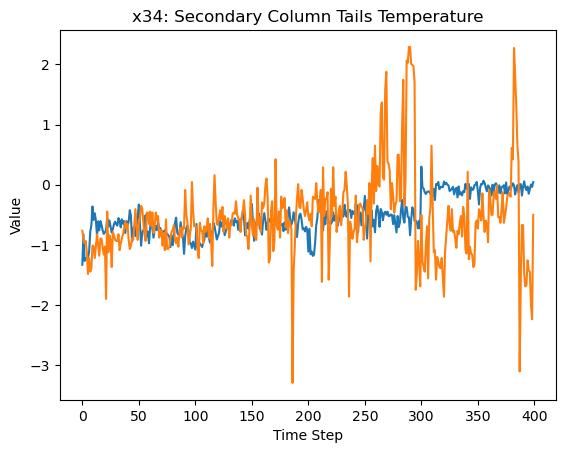

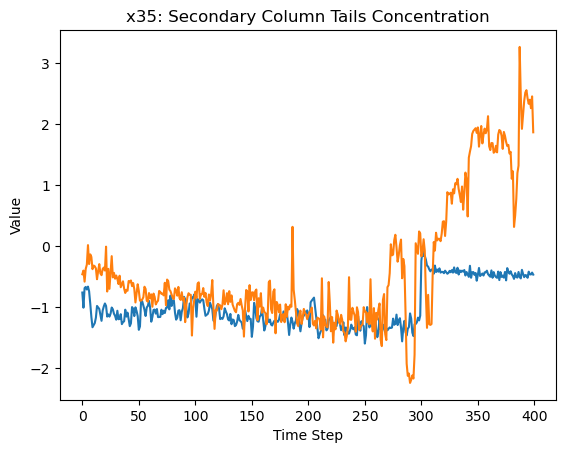

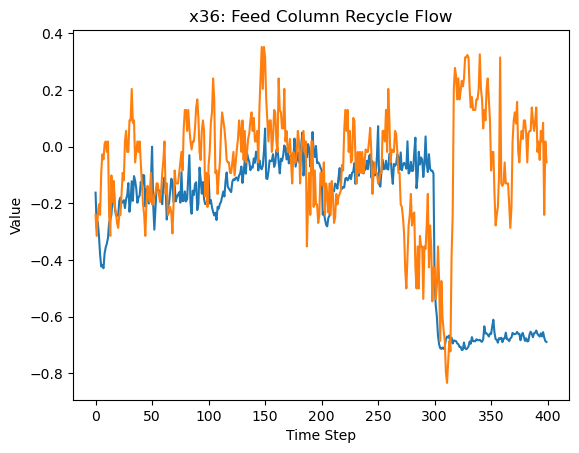

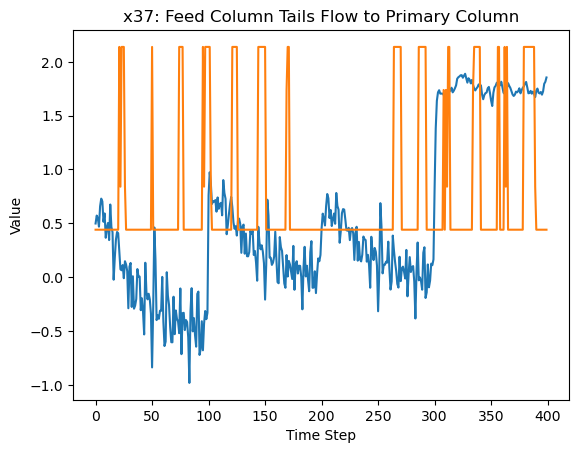

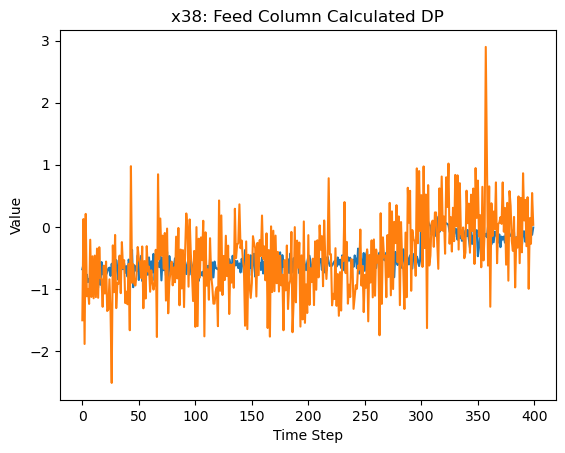

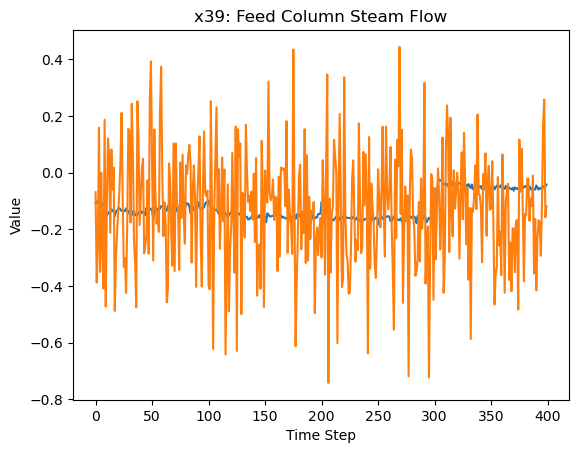

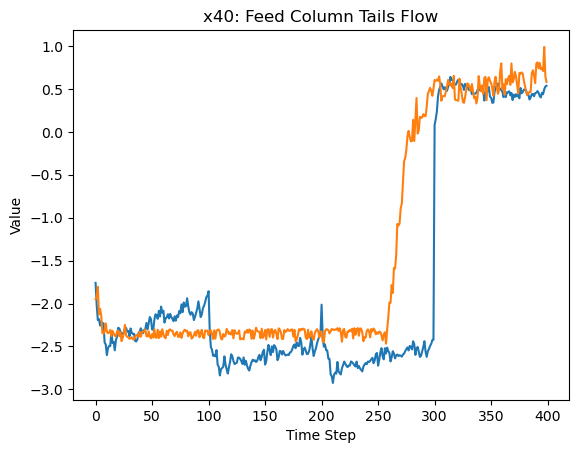

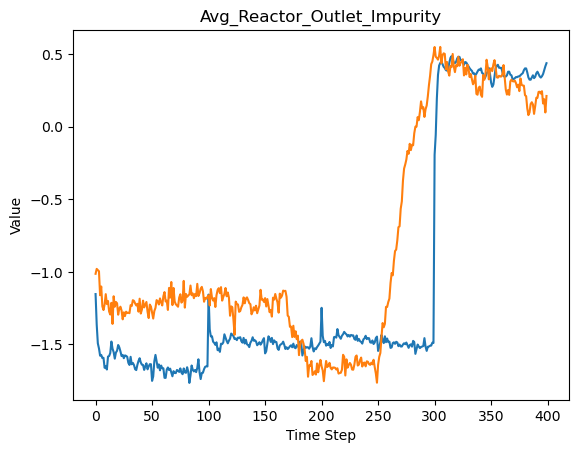

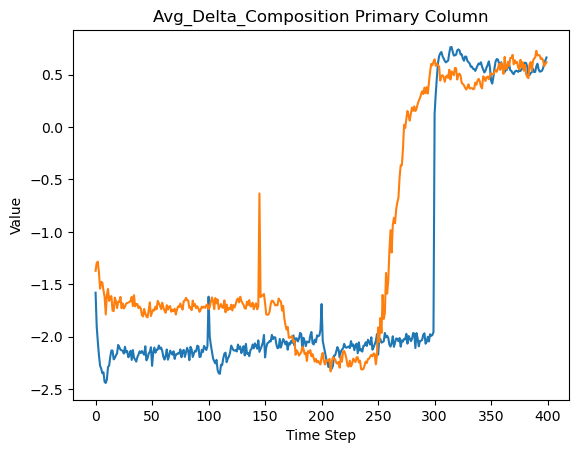

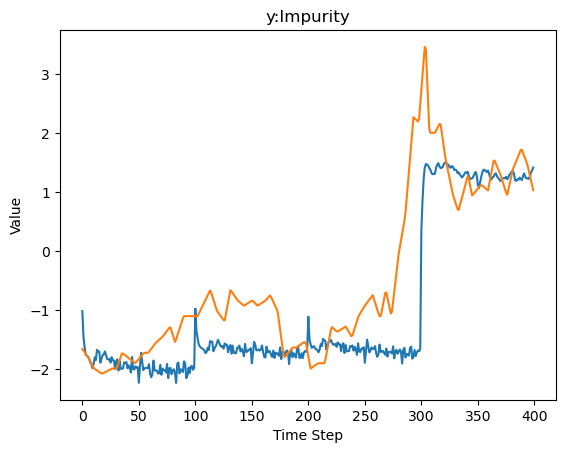

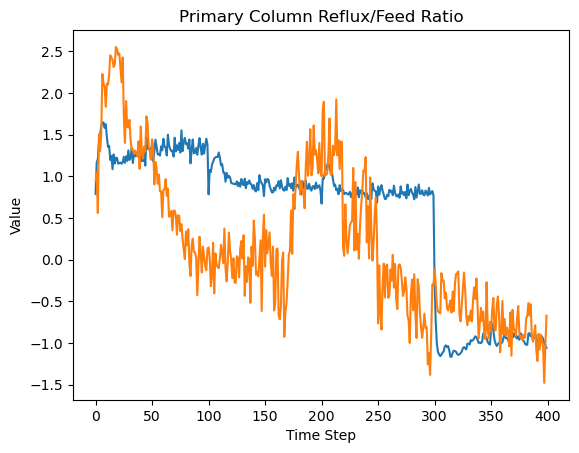

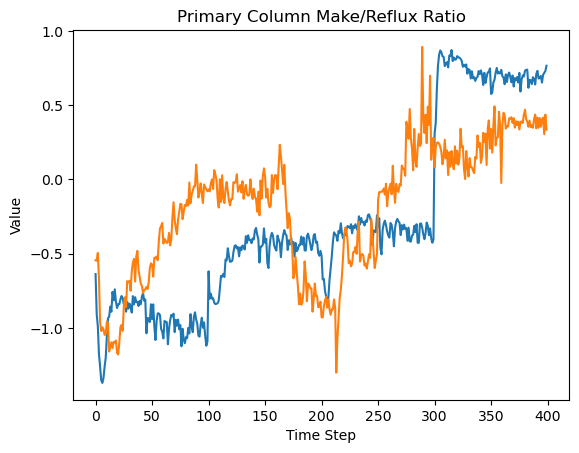

In [65]:
test_data = test_data.values
# Iterate over and plot each feature of the first sequence
for i in range(input_dim):
    plt.figure(i)
    plt.plot(generated_data[:,i])
    plt.plot(test_data[:,i])
    plt.title(f'{column_names[i]}')  # Use column name as the title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
plt.show()